In [19]:
import datetime as dt
import gc
import os
import pickle as pkl
import time as timer
from functools import partial
from pathlib import Path

import cartopy as ctp
import cupy as cp  # noqa
import IPython.display as disp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, rgb2hex, ListedColormap, BoundaryNorm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.cm import ScalarMappable
import numpy as np
import numpy.random as ran
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import xarray as xr
import hvplot.xarray  # noqa
import holoviews as hv
from ipywidgets import HTML, IntProgress, Text
from scripts.util import *

from cdo import Cdo
os.environ["CDO"] = "/project/pr133/hbanderi/miniconda3/envs/env/bin/cdo"

from nco import Nco
os.environ[
    "NCOpath"
] = "/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/NCO/5.0.4-CrayGNU-21.09/bin"
os.environ[
    "PATH"
] += ":/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/NCO/5.0.4-CrayGNU-21.09/bin"

%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.11 ms


## Initialize all parameters, store in metadata file

In [20]:
n_sel = 100  # how many times we randomly select runs, make it n_sel % n_engine = 0
alpha = 0.05  # significance level
n_mem = 100  # members per ensemble

freq = "1D"  # supersampling frequency
n_sam = {f"{i}D": i * 75 for i in range(1, 8)}
n_sam["1w"] = 500
n_sam["2w"] = 1000
n_sam["1M"] = 2000
n_sam["3M"] = 5000
n_sam["1MS"] = 2000
n_sam["3MS"] = 5000
crit_val = {}
for freq, n_s in n_sam.items():
    u_crit = int(
        sstats.norm.ppf(
            q=1 - alpha / 2,
            loc=n_s ** 2 / 2,
            scale=np.sqrt((n_s ** 2 * (2 * n_s + 1)) / 12),
        )
    )
    ndf = 2 * n_s - 2
    t_crit = sstats.t.ppf(q=1 - alpha / 2, df=ndf)  # n_sam = 17
    c_alpha = np.sqrt(-np.log(alpha / 2) / 2)
    d_crit = c_alpha * np.sqrt(2 / n_s)  # Kolmogorov-Smirnov
    crit_val[freq] = {
        "KS": d_crit,
        "MWU": u_crit,  # to have a test with > so it has the same function as the others
        "T": t_crit,
    }
replace = False  # to bootstrap or not to bootstrap
nbins = 100  # Kolmogorov-Smirnov, Christian's code
decision_quantile = 0.95
boundary_size = 10  # How many points to exclude on each side

# The time period for the tests :
nicertsta = pd.to_datetime(TSTA).strftime("%Y-%m-%d")
n_months = 120  # 10 years
files_to_load = [f"lffdm{x}.nc" for x in MONTHS]
# Different structures : a forward map from list to nested dictionaries
variablemap = {  # add units ? make dict of dataclasses ? make dict of dicts ?
    "t_850hPa": ["24h_plev", "T", 2, "Temperature at 850hPa"],
    "u_200hPa": ["24h_plev", "U", 0, "U at 200hPa"],
    "v_200hPa": ["24h_plev", "V", 0, "V at 200hPa"],
    "qv_500hPa": ["24h_plev", "QV", 1, "QV at 500hPa"],
    #########################################################################
    "fi_200hPa": ["12h_plev", "FI", 0, "Geopotential at 200hPa"],
    "fi_500hPa": ["12h_plev", "FI", 1, "Geopotential at 500hPa"],
    #########################################################################
    "u_100m": ["24h_100zlev", "U", 0, "U at 100m"],
    "v_100m": ["24h_100zlev", "V", 0, "V at 100m"],
    #########################################################################
    "u_10m": ["24h", "U_10M", "U at 10m"],
    "v_10m": ["24h", "V_10M", "V at 10m"],
    "vmax_10m": ["24h", "VMAX_10M", "Max. V at 2m"],
    "vabsmx_2m": ["24h", "VABSMX_10M", "Max. V at 2m w/o gusts"],
    "pmsl": ["24h", "PMSL", "Mean sea-level pressure"],
    "tot_prec": ["24h", "TOT_PREC", "Precipitation"],
    "tmax_2m": ["24h", "TMAX_2M", "Max. Temperature at 2m"],
    "tmin_2m": ["24h", "TMIN_2M", "Min. Temperature at 2m"],
    "w_snow": ["24h", "W_SNOW", "Surface snow amount"],
    "h_snow": ["24h", "H_SNOW", "Surface snow height"],
    "t_so_first": ["24h", "T_SO", 0, "Soil temperature at -5mm"],
    "t_so_third": ["24h", "T_SO", 2, "Soil temperature at -70mm"],
    "t_so_fifth": ["24h", "T_SO", 4, "Soil temperature at -340mm"],
    "w_so_first": ["24h", "W_SO", 0, "Soil moisture at -5mm"],
    "w_so_third": ["24h", "W_SO", 2, "Soil moisture at -70mm"],
    "w_so_fifth": ["24h", "W_SO", 4, "Soil moisture at -340mm"],
    "asob_s": ["24h", "ASOB_S", "Avg. surf. downward SW rad."],
    "asob_t": ["24h", "ASOB_T", "Net TOA downward SW rad."],
    "athb_t": ["24h", "ATHB_T", "Avg. TOA out LW rad."],
    "athb_s": ["24h", "ATHB_S", "Avg. surf. out LW rad."],
    "ashfl_s": ["24h", "ASHFL_S", "Avg. surf. sensible heat flux"],
    "alhfl_s": ["24h", "ALHFL_S", "Avg. surf. latent heat flux"],
    "athd_s": ["24h", "ATHD_S", "Avg. surf. LW downwelling flux"],
    "athu_s": ["24h", "ATHU_S", "Avg. surf. LW upwelling flux"],
    "aswdifu_s": ["24h", "ASWDIFU_S", "Avg. surf. SW diffuse upw. flux"],
    #########################################################################
    "tqi": ["12h", "TQI", "Total cloud ice"],
    "tqv": ["12h", "TQV", "Total water vapor"],
    "t_2m": ["12h", "T_2M", "Temperature at 2m"],
    "td_2m": ["12h", "TD_2M", "Dew point temperature at 2m"],
    "qv_2m": ["12h", "QV_2M", "Spec. humidity at 2m"],
    "t_s": ["12h", "T_S", "Surface temperature"],
    "relhum_2m": ["12h", "RELHUM_2M", "Rel. hum. at 2M"],
    "hpbl": ["12h", "HPBL", "Height of the boundary layer"],
    "clct": ["12h", "CLCT", "Total cloud cover"],
    "clcl": ["12h", "CLCL", "Low cloud cover"],
    "clcm": ["12h", "CLCM", "Medium cloud cover"],
    "clch": ["12h", "CLCH", "High cloud cover"],
    "cape_ml": ["12h", "CAPE_ML", "CAPE of mean surf. layer parcel"],
    "ps": ["12h", "PS", "Surface pressure"],
}
dirnames = np.unique([value[0] for value in variablemap.values()])
# All the data, changes depending on which analysis we do
# diff is alias for C50
ensembles = {
    "main": np.array(["control", "control2", "ref", "sp", "diff"]),
    "sensi": np.array(["control", "control2", "ref", "C33", "C41", "diff"]),
    "comb": np.array(["control", "control2", "ref", "sp", "C33", "C41", "diff"]),
}
paths = {key: [f"{PATHBASE}/{f}/" for f in ensembles[key]] for key in ensembles}
n_ens = {key: len(paths[key]) for key in ensembles}
titles = {
    "main": ["Identical test, $C=0.25$", "Single precision, $C=0.25$", "Modified diffusion, $C=0.50$"],
    "sensi": ["Identical test, $C=0.25$", "Modified diffusion, $C=0.33$", "Modified diffusion, $C=0.41$", "Modified diffusion, $C=0.50$"],
    "comb": ["Identical test, $C=0.25$", "Single precision, $C=0.25$", "Modified diffusion, $C=0.33$", "Modified diffusion, $C=0.41$", "Modified diffusion, $C=0.50$"],
}
ref = {key: np.where(ensembles[key] == "ref")[0][0] for key in ensembles}
notref = {key: np.where(ensembles[key] != "ref")[0] for key in ensembles}
ensembles_in_results = {
    key: np.delete(value, ref[key]) for key, value in ensembles.items()
}
control = {
    key: np.where(ensembles_in_results[key] == "control")[0][0]
    for key in ensembles_in_results
}
notcontrol = {
    key: np.where(ensembles_in_results[key] != "control")[0]
    for key in ensembles_in_results
}
ensembles_in_decisions = {
    key: [x for x in value if x not in ["control", "ref"]]
    for key, value in ensembles.items()
}

metadata = {  # Need a dict move around more easily
    "n_sel": n_sel,
    "alpha": alpha,
    "n_mem": n_mem,
    "n_sam": n_sam,
    "crit_val": crit_val,
    "replace": replace,
    "nbins": nbins,
    "tsta": TSTA,
    "n_months": n_months,
    "n_ens": n_ens,
    "ensembles": ensembles,
    "ensembles_in_results": ensembles_in_results,
    "ensembles_in_decisions": ensembles_in_decisions,
    "ref": ref,
    "notref": notref,
    "control": control,
    "notcontrol": notcontrol,
    "variablemap": variablemap,
    "months_per_chunk": 1,
    "freq": freq,
    "boundary_size": boundary_size,
    "files_to_load": files_to_load,
    "decision_quantile": decision_quantile,
    "rounding": None,
}

with open(f"{PATHBASE}/main/metadata.pickle", "wb") as handle:
    pkl.dump(metadata, handle)
with open(f"{PATHBASE}/sensi/metadata.pickle", "wb") as handle:
    pkl.dump(metadata, handle)
with open(f"{PATHBASE}/comb/metadata.pickle", "wb") as handle:
    pkl.dump(metadata, handle)

for ana in ensembles.keys():
    if not os.path.isdir(f"{PATHBASE}/results/{ana}_{freq}"):
        os.mkdir(f"{PATHBASE}/results/{ana}_{freq}")
    with open(f"{PATHBASE}/results/{ana}_{freq}/metadata.pickle", "wb") as handle:
        pkl.dump(metadata, handle)

time: 20 ms


## Write concat batch files

In [ ]:
wall_clock_time = {"12": "14:00:00", "24": "08:00:00"}
ana = "sensi"
scripts = "/users/hbanderi/cosmo-sp/scripts"
debug = False

for varname, value in metadata["variablemap"].items():
    h = value[0][:2]
    f = open(f"{scripts}/batch_scripts/concat/{varname}.sbatch", "w")

    f.writelines(
        [
            "#!/bin/bash -l\n",
            f"#SBATCH --job-name='concat_{varname}'\n",
            f"#SBATCH --output={scripts}/logs/concat_{ana}/{varname}.out\n",
            f"#SBATCH --error={scripts}/logs/concat_{ana}/{varname}.err\n",
            "#SBATCH --account='pr133'\n",
        ]
    )
    if debug:
        f.write(f"#SBATCH --time=00:05:00\n")
    else:
        f.write(f"#SBATCH --time={wall_clock_time[h]}\n")
    f.writelines(
        [
            "#SBATCH --nodes=1\n",
            "#SBATCH --ntasks-per-core=1\n",
            "#SBATCH --ntasks-per-node=1\n",
            "#SBATCH --cpus-per-task=24\n",
            f'#SBATCH --partition={"debug" if debug else "normal"}\n',
            "#SBATCH --constraint=gpu\n",
            "#SBATCH --hint=multithread\n",
            "\n",
            "export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n",
            "\n",
            "conda activate pers\n",
            f"srun -o python {scripts}/concat.py {varname} --ana {ana} &>> {scripts}/logs/concat_{ana}/{varname}.python.out\n",
        ]
    )

    f.close()

Data is first stored, for each ensemble (ensembles), in monthly files stored in either of 5 directories according to the gribout file (see dirnames) :
* control
  * 0000   
    * 12h
      * lffm198901.nc   
      * lffm198902.nc
      * ...
    * 12h_plev          
      * lffm198901.nc  
      * lffm198902.nc
      * ...
    * 24h
      * lffm198901.nc   
      * lffm198902.nc
      * ...
    * 24h_plev
      * lffm198901.nc  
      * lffm198902.nc
      * ...
    * 24h_100zlev
      * lffm198901.nc  
      * lffm198902.nc
      * ...
  * 0001
  * ...
* control2 (a.k.a. identical test, a.k.a. C25)
  * 0000
  * ...
* ref
* sp
* diff (a.k.a. C50)
* C33
* C41

We want to rewrite one data file per semester and per variable. This choice was roughly estimated to optimize the number of operations that can be done by a 24 cores at once, while staying below 64GB of RAM

This is done in concat.py

## Write test batch files

The gridpoint-per-gridpoint statistical tests are implemented in the file scripts/one_ks.py. This following cell writes batch scripts that are used to perform them for a given variable. A few points on this :

* A switch can change the statistical test : "T" for student-t test, "KS" for Kolmogorov-Smirnov and "MWU" for Mann-Whitney U.  
* In the third cell "freq", the oversampling frequency, was defined, and it also defines the subsampling size (17 times the number of days)  

In [4]:
wall_clock_time = {"12": "23:00:00", "24": "11:00:00"}
test = "KS"
ana = "comb"
freq = "1D"
scripts = "/users/hbanderi/cosmo-sp/scripts"
debug = False

with open(f"{PATHBASE}/{ana}/metadata.pickle", "rb") as handle:
    metadata = pkl.load(handle)

for varname, value in metadata["variablemap"].items():
    h = value[0][:2]
    f = open(f"{scripts}/batch_scripts/test/{varname}.sbatch", "w")

    f.write("#!/bin/bash -l \n")
    f.write(f"#SBATCH --job-name='{test}_{varname}_{ana}_{freq}'\n")
    f.write(f"#SBATCH --output={scripts}/logs/{test}_{ana}_{freq}/{varname}.out\n")
    f.write(f"#SBATCH --error={scripts}/logs/{test}_{ana}_{freq}/{varname}.err\n")
    f.write("#SBATCH --account='pr133'\n")
    if debug:
        f.write(f"#SBATCH --time=00:05:00\n")
    else:
        f.write(f"#SBATCH --time={wall_clock_time[h]}\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=24\n")
    f.write(
        f'#SBATCH --partition={"debug" if debug else "normal"}\n',
    )
    f.write("#SBATCH --constraint=gpu\n")
    f.write("#SBATCH --hint=multithread\n")
    f.write("\n")
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("\n")
    f.write("source /users/hbanderi/setup_conda.sh\n")
    f.write(
        f"srun -o python {scripts}/one_ks.py {varname} --freq {freq} --test {test} --ana {ana} &>> {scripts}/logs/{test}_{ana}_{freq}/{varname}.python.out\n"
    )

    f.close()

time: 156 ms


## Re concat, using xarray because I am lazy

In [19]:
PATHBASE_PROJ = '/project/pr133/hbanderi/data_backup/new_100members'
PATHBASE = "/scratch/snx3000/hbanderi/data"
da = xr.open_dataset(f"{PATHBASE_PROJ}/main/t_850hPa198901.nc")['T']
da.rlat.to_netcdf(f'{PATHBASE}/gridinfo/rlat.nc')
da.rlon.to_netcdf(f'{PATHBASE}/gridinfo/rlon.nc')
da.lat.to_netcdf(f'{PATHBASE}/gridinfo/lat.nc')
da.lon.to_netcdf(f'{PATHBASE}/gridinfo/lon.nc')
da = xr.open_dataset(f"{PATHBASE_PROJ}/main/u_200hPa198901.nc")['U']
da.slatu.to_netcdf(f'{PATHBASE}/gridinfo/slatu.nc')
da.slonu.to_netcdf(f'{PATHBASE}/gridinfo/slonu.nc')
da.srlon.to_netcdf(f'{PATHBASE}/gridinfo/srlon.nc')
da = xr.open_dataset(f"{PATHBASE_PROJ}/main/v_200hPa198901.nc")['V']
da.slatv.to_netcdf(f'{PATHBASE}/gridinfo/slatv.nc')
da.slonv.to_netcdf(f'{PATHBASE}/gridinfo/slonv.nc')
da.srlat.to_netcdf(f'{PATHBASE}/gridinfo/srlat.nc')

time: 324 ms


In [10]:
progress_bar_1 = IntProgress(min=0, max=len(variablemap) - 1)
progress_bar_2 = IntProgress(min=0, max=len(MONTHS) - 1)
text = HTML()
display(progress_bar_1, progress_bar_2, text)
for k, month in enumerate(MONTHS):
    progress_bar_1.value = 0
    for varname in variablemap:
        if not os.path.isfile(f"{PATHBASE}/comb/{varname}{month}.nc"):
            bigname = variablemap[varname][1]
            text.value = f'{varname}, {month}'
            da = loaddarr(varname, bigname, ensembles['sensi'], k, 'sensi', False, None, False)
            da2 = xr.open_dataset(f"{PATHBASE}/main/{varname}{month}.nc").sel(member=np.arange(3, 500, 5))[bigname].squeeze()
            da2 = da2.coarsen(member=1).construct(member=("member", "ensemble"))
            da2 = da2.transpose("ensemble", "time", ..., "member").assign_coords({'ensemble': ['sp'], 'member': np.arange(100)})
            da = xr.concat([da, da2], dim='ensemble').sel(ensemble=ensembles['comb'])
            da.to_netcdf(f"{PATHBASE}/comb/{varname}{month}.nc")
        progress_bar_1.value += 1
    progress_bar_2.value += 1

IntProgress(value=0, max=46)

IntProgress(value=0, max=119)

HTML(value='')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



time: 16min 52s


## Redo avgs

In [3]:
ana = 'comb'
freq = '1D'
test = 'KS'
text = HTML()
display(text)
for varname in variablemap:
    pat = Path(f"{PATHBASE}/results/{ana}_{freq}/avg_{varname}_{test}.nc")
    if pat.is_file():
        continue
    rlonname, lonname, rlatname, latname = get_grid_names(varname)
    avgres = []
    for month in MONTHS:
        text.value = f'{varname}, {month}'
        thispat = Path(f"{PATHBASE}/results/{ana}_{freq}/{varname}_{test}_{month}.nc")
        results = xr.open_dataarray(thispat.as_posix(), chunks={'time': 200, rlonname: -1, rlatname: -1}).mean(dim=[rlonname, rlatname]).compute(n_workers=24, memory_limit='2GiB')
        avgres.append(results)
    avgres = xr.concat(avgres, dim='time')
    avgres.to_netcdf(pat.as_posix())

HTML(value='')

time: 2h 13min 29s


# Redo sp with rounding

In [3]:
test = 'KS'
ana = 'comb'
freq = '1D'
subset = ['clct', 'clcl', 'clcm', 'clch']
for varname in subset:
    bigname = variablemap[varname][1]
    avgres = xr.open_dataarray(f'{PATHBASE}/results/{ana}_{freq}_rounding/avg_{varname}_{test}.nc')
    corrected_sp = xr.open_mfdataset(
        [f'{PATHBASE}/results/{ana}_{freq}_rounding/avg_{varname}_{test}_{month}_v2.nc' for month in MONTHS], 
        combine='nested', concat_dim='time'
    )[HERE]
    corrected_sp.to_netcdf(f'{PATHBASE}/results/{ana}_{freq}_rounding/avg_{varname}_{test}_v2.nc')

time: 18.7 s


# FDR

In [93]:
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "main"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
f1 = IntProgress(max=2 * len(variablemap))
f2 = IntProgress(max=N_MONTHS)
t1 = HTML(value="Working on : ")
t2 = HTML(value="Last test took : ")
t3 = HTML(value="Last variable took : ")
display(f1, f2, t1, t2, t3)
alpha = 0.1
roundings = [2, 4, None]
d = {}
p = {}
decisions = {}
test = "KS"
for rounding in roundings:
    d[rounding] = {}
    p[rounding] = {}
    decisions[rounding] = {}
    for varname in list(variablemap.keys())[-6:]:
        f2.value = 0
        actualfreq = (
            "12h" if (freq == "1D" and variablemap[varname][0][:2] == "12") else freq
        )
        coords = coords_avgdecs(varname, ana, actualfreq, ensembles_in_decisions)
        shape = [len(x) for x in coords.values()]
        decisions[rounding][varname] = xr.DataArray(
            np.zeros(shape, dtype=bool), coords=coords
        )
        bigname = variablemap[varname][1]
        j = 0
        bigt = timer.time()
        for month in range(101, 102):
            t1.value = f"Working on {varname}, {month}th month, rounding: {rounding}"
            t = timer.time()
            darr = loaddarr(
                varname, bigname, ensembles, month, ana, values=False, bs=bs
            )
            d[rounding][varname] = cp.zeros((len(ensembles_in_decisions), *darr.shape[1:4]))
            p[rounding][varname] = cp.zeros((len(ensembles_in_decisions), *darr.shape[1:4]))
            b = cp.asarray(darr.sel(ensemble="ref"))
            b = sanitize(b, rounding)
            to_do, other_args = wraptest(b, test)
            for i, ens in enumerate(ensembles_in_decisions):
                a = cp.asarray(darr.sel(ensemble=ens))
                a = sanitize(a, rounding)
                d[rounding][varname][i] = cp.nan_to_num(to_do(a, *other_args), nan=0)
                p[rounding][varname][i] = p_wrapper(
                    test, d[rounding][varname][i], 100
                )  # recycling yay
            shape = p[rounding][varname].shape
            p[rounding][varname] = p[rounding][varname].reshape(
                (shape[0], shape[1], shape[2] * shape[3])
            )
            p[rounding][varname] = cp.sort(p[rounding][varname], axis=-1)
            l = j + darr.shape[1]
            nump = shape[2] * shape[3]
            decisions[rounding][varname][:, j:l] = cp.any(
                p[rounding][varname]
                <= cp.arange(1, nump + 1) / nump * alpha, axis=-1,
            ).get() 
            j = l
            f2.value += 1
            t2.value = f"Last test took {timer.time() - t:.3f}s"
        t3.value = f"Last variable took {timer.time() - bigt:.3f}s"
        f1.value += 1
        cp.cuda.Device().synchronize()
    # decisions.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}/FDR_decisions_{test}_{varname}.nc")

IntProgress(value=0, max=94)

IntProgress(value=0, max=120)

HTML(value='Working on : ')

HTML(value='Last test took : ')

HTML(value='Last variable took : ')

time: 1min 53s


In [ ]:
with open('p_many_round.pkl', 'wb') as handle:
    pkl.dump(p, handle)
with open('d_many_round.pkl', 'wb') as handle:
    pkl.dump(d, handle)

In [3]:
with open('p_many_round.pkl', 'rb') as handle:
    p = pkl.load(handle)
with open('d_many_round.pkl', 'rb') as handle:
    d = pkl.load(handle)

time: 10.2 s


#### Where are the rejections ?

In [94]:
basep = {}
decisions = {}
roundings = list(p.keys())
for varname in p[2]:
    dd = {}
    pp = {}
    for rounding in roundings:
        thisp = p_wrapper(
            'KS', d[rounding][varname], 100
        )
        shape = thisp.shape
        thisp_sorted = thisp.reshape(thisp.shape[0], thisp.shape[1], thisp.shape[2] * thisp.shape[3]) # not sorted yet
        idxs = cp.argsort(thisp_sorted, axis=-1)
        idxs_inverse = cp.argsort(idxs, axis=-1)
        thisp_sorted = cp.take_along_axis(thisp_sorted, idxs, axis=-1)
        nump = thisp_sorted.shape[-1]
        rejected = thisp_sorted < cp.arange(1, nump + 1)[None, None, :] / nump * 0.1
        rejected = cp.take_along_axis(rejected, idxs_inverse, axis=-1)
        freq = variablemap[varname][0][:3]
        dims, coords = coords_decisions(varname, 'main', freq, ensembles_in_decisions, metadata['boundary_size'])
        dims['time'] = dims['time'][dims['time'].strftime('%Y%m') == MONTHS[101]]
        dd[rounding] = xr.DataArray(rejected.reshape(thisp.shape).get(), coords=dims).assign_coords(coords).rename(f'Rejection_FDR_{varname}')
        pp[rounding] = xr.DataArray(thisp.get(), coords=dims).assign_coords(coords).rename(f'Raw_p_{varname}')
    basep[varname] = xr.concat(list(pp.values()), dim='rounding').assign_coords({'rounding': roundings})
    decisions[varname] = xr.concat(list(dd.values()), dim='rounding').assign_coords({'rounding': roundings})

time: 1.18 s


In [95]:
p = xr.Dataset(basep)
decisions = xr.Dataset(decisions)
decisions = decisions.sel(time=decisions.time.dt.hour==0)
final_decisions = decisions.any(dim=['rlon', 'rlat'])
averaged_decisions = decisions.mean(dim='time')

time: 43.3 ms


In [96]:
list(decisions.keys())

['clct', 'clcl', 'clcm', 'clch', 'cape_ml', 'ps']

time: 1.69 ms


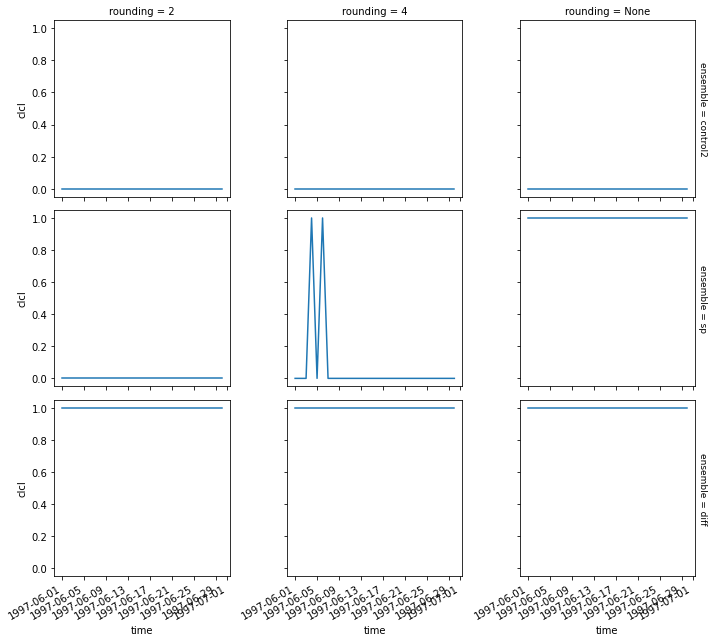

time: 2.01 s


In [98]:
final_decisions['clcl'].plot(col='rounding', row='ensemble')

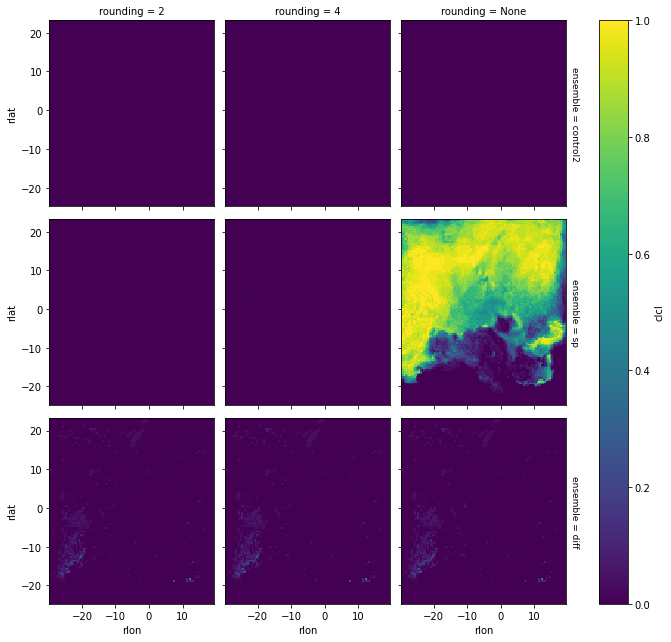

time: 1.24 s


In [104]:
averaged_decisions['clcl'].plot(col='rounding', row='ensemble')

#### Full results - like viz

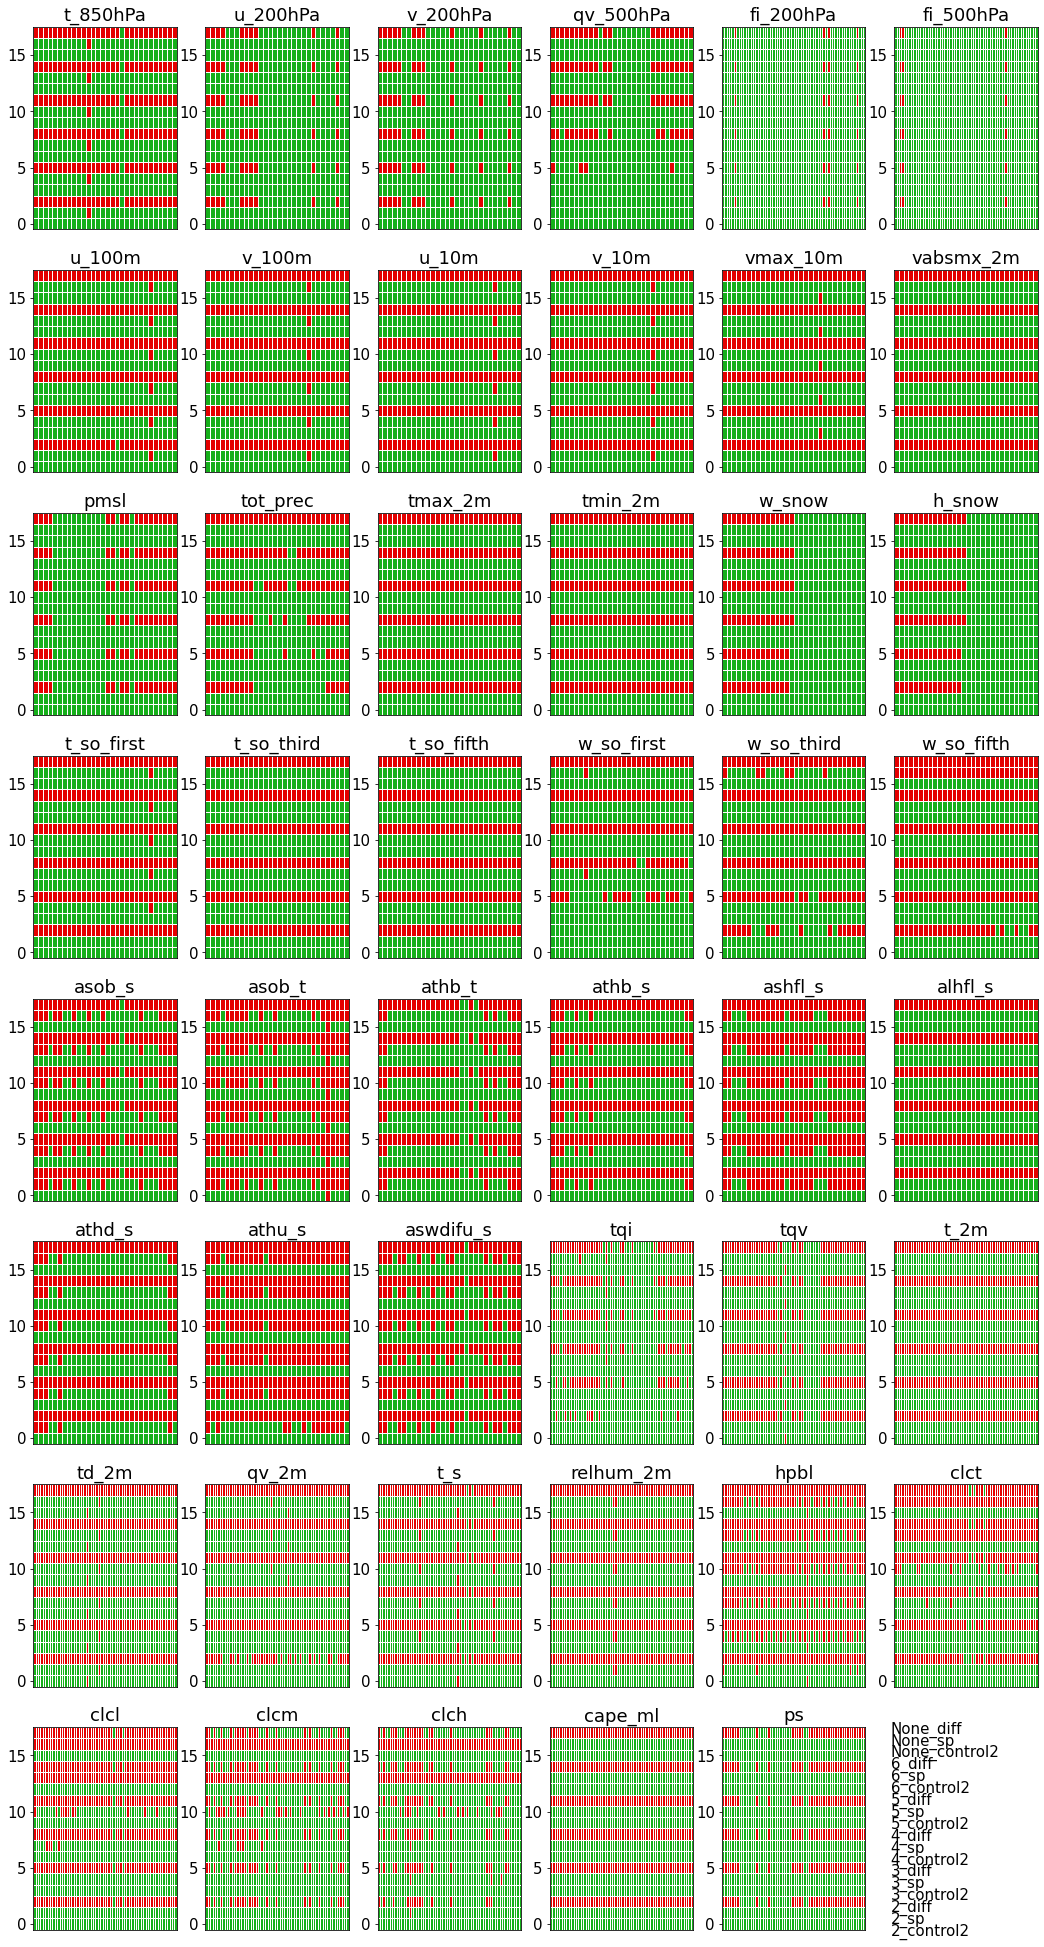

time: 3.59 s


In [15]:
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "main"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
roundings = [2, 3, 4, 5, 6, None]
fig, axes = plt.subplots(8, 6, figsize=(18, 35))
axes = axes.flatten()
roun_and_ens = [
    f"{rounding}_{ens}" for rounding in roundings for ens in ensembles_in_decisions
]
for i, varname in enumerate(p[None].keys()):
    ax = axes[i]
    h = variablemap[varname][0][:3]
    thistime = month_range(MONTHS[101], h)
    shape = (len(roun_and_ens), len(thistime))
    to_plot = xr.DataArray(
        np.empty(shape, dtype=bool),
        coords={"roun_and_ens": roun_and_ens, "time": thistime},
        name=varname,
    )
    for k, ens in enumerate(ensembles_in_decisions):
        for j, rounding in enumerate(roundings):
            shape = p[rounding][varname].shape
            decisions = cp.any(
                p[rounding][varname][k] <= cp.arange(1, shape[-1] + 1) / shape[-1] * alpha, axis=-1,
            ).get()
            to_plot.loc[f"{rounding}_{ens}", :] = decisions # stupid stupid stupid
    ax.pcolormesh(
        to_plot.time,
        np.arange(to_plot.shape[0]),
        to_plot.values,
        cmap=CMAP,
        shading="nearest",
        vmax=1,
        vmin=0,
        rasterized=True,
        linewidth=1,
        edgecolors="white",
    )
    ax.set_title(varname)
    ax.set_xticks([])
    ax.set_xticklabels([])
ax = axes[-1]
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks(np.arange(len(roun_and_ens)))
ax.set_yticklabels(roun_and_ens, ha="left")
ax.spines[["right", "top", "bottom", "left"]].set_visible(False)
ax.tick_params(axis="both", which="major", length=0)

#### Look at FDR for a month

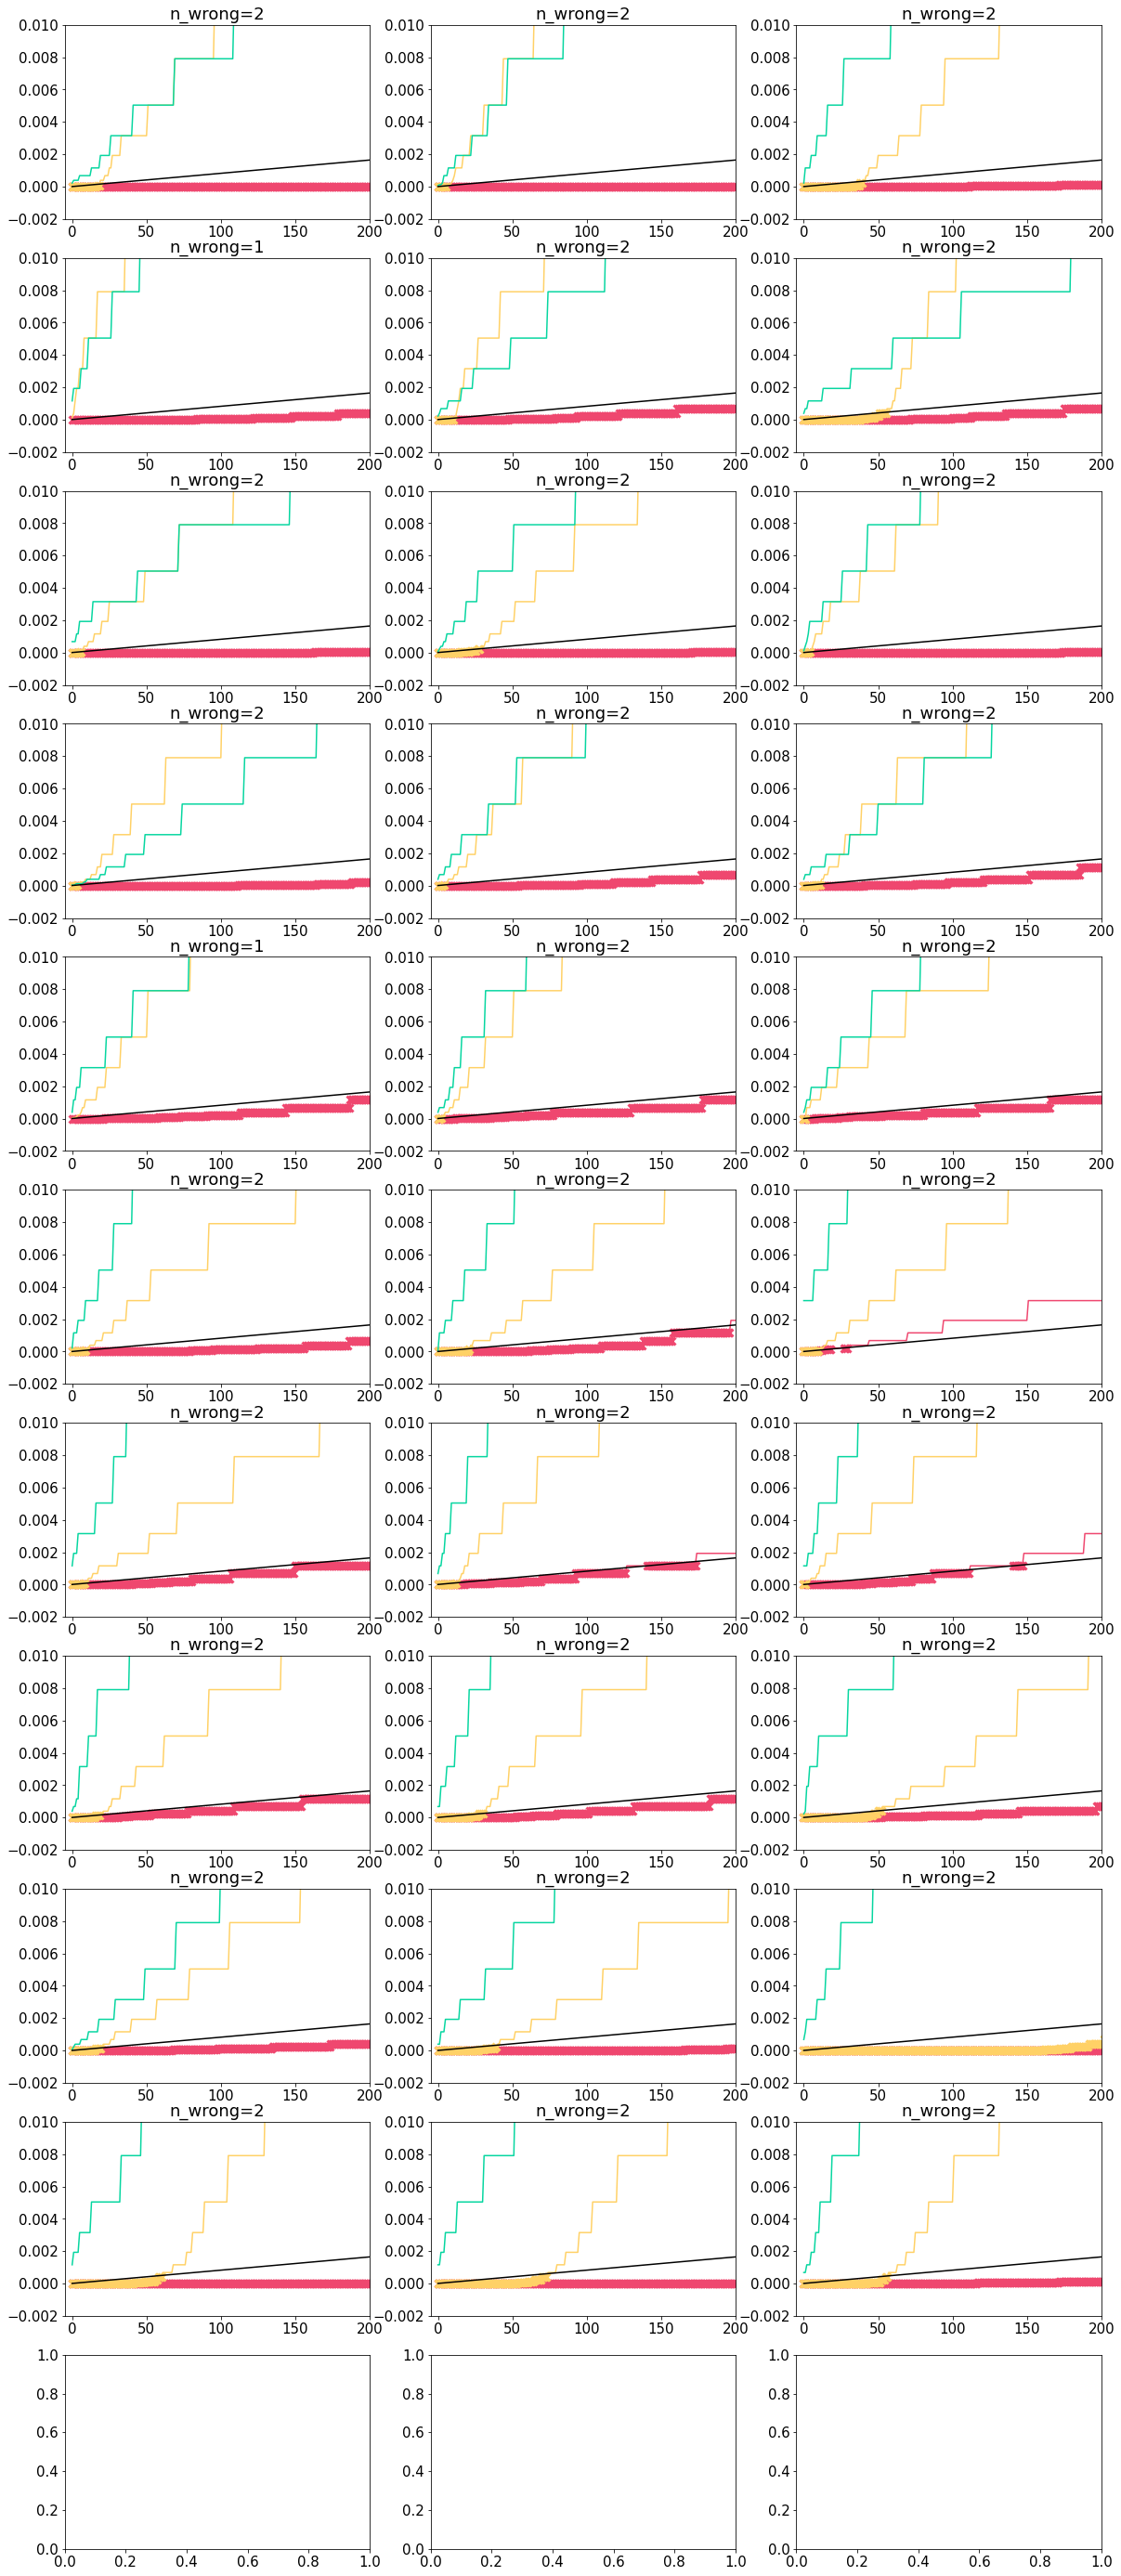

time: 2.91 s


In [8]:
fig, axes = plt.subplots(11, 3, figsize=(20, 50))
axes = axes.flatten()
varname = "athu_s"
for i in range(30):
    ax = axes[i]
    slope = (
        np.arange(1, p[4][varname].shape[-1] + 1) / p[4][varname].shape[-1] * 0.1
    )
    x = np.arange(len(slope))
    nwro = 0
    for j in range(2, -1, -1):
        thesep = p[4][varname][j, i].get()
        wrong = thesep <= slope
        ax.plot(thesep, color=COLORS[2::-1][j], label=ensembles_in_decisions[j])
        ax.plot(x[wrong], thesep[wrong], "x", color=COLORS[2::-1][j], ms=8, mew=3)
        nwro += np.any(wrong)
    ax.plot(x, slope, color="k")
    ax.set_title(f"n_wrong={nwro}")
    ax.set_xlim([-5, 200])
    ax.set_ylim([-0.002, 0.01])
    if i == 30:
        ax.legend()

#### Distance plots

In [ ]:
fig, axes = plt.subplots(11, 3, figsize=(20, 50))
axes = axes.flatten()
t_crit = metadata["crit_val"]["T"]
for i in range(30):
    ax = axes[i]
    nwro = 0
    for j in range(2, -1, -1):
        thesed = cp.sort(d["T"][varname][j, i].flatten()).get()
        ax.plot(thesed, color=COLORS[2::-1][j], label=ensembles_in_decisions[j])
    ax.hlines([-t_crit, t_crit], 0, len(thesed) - 1, color="black", ls="--")
    # ax.set_xlim([-2, 200])
    # ax.set_ylim([-0.002, 0.01])

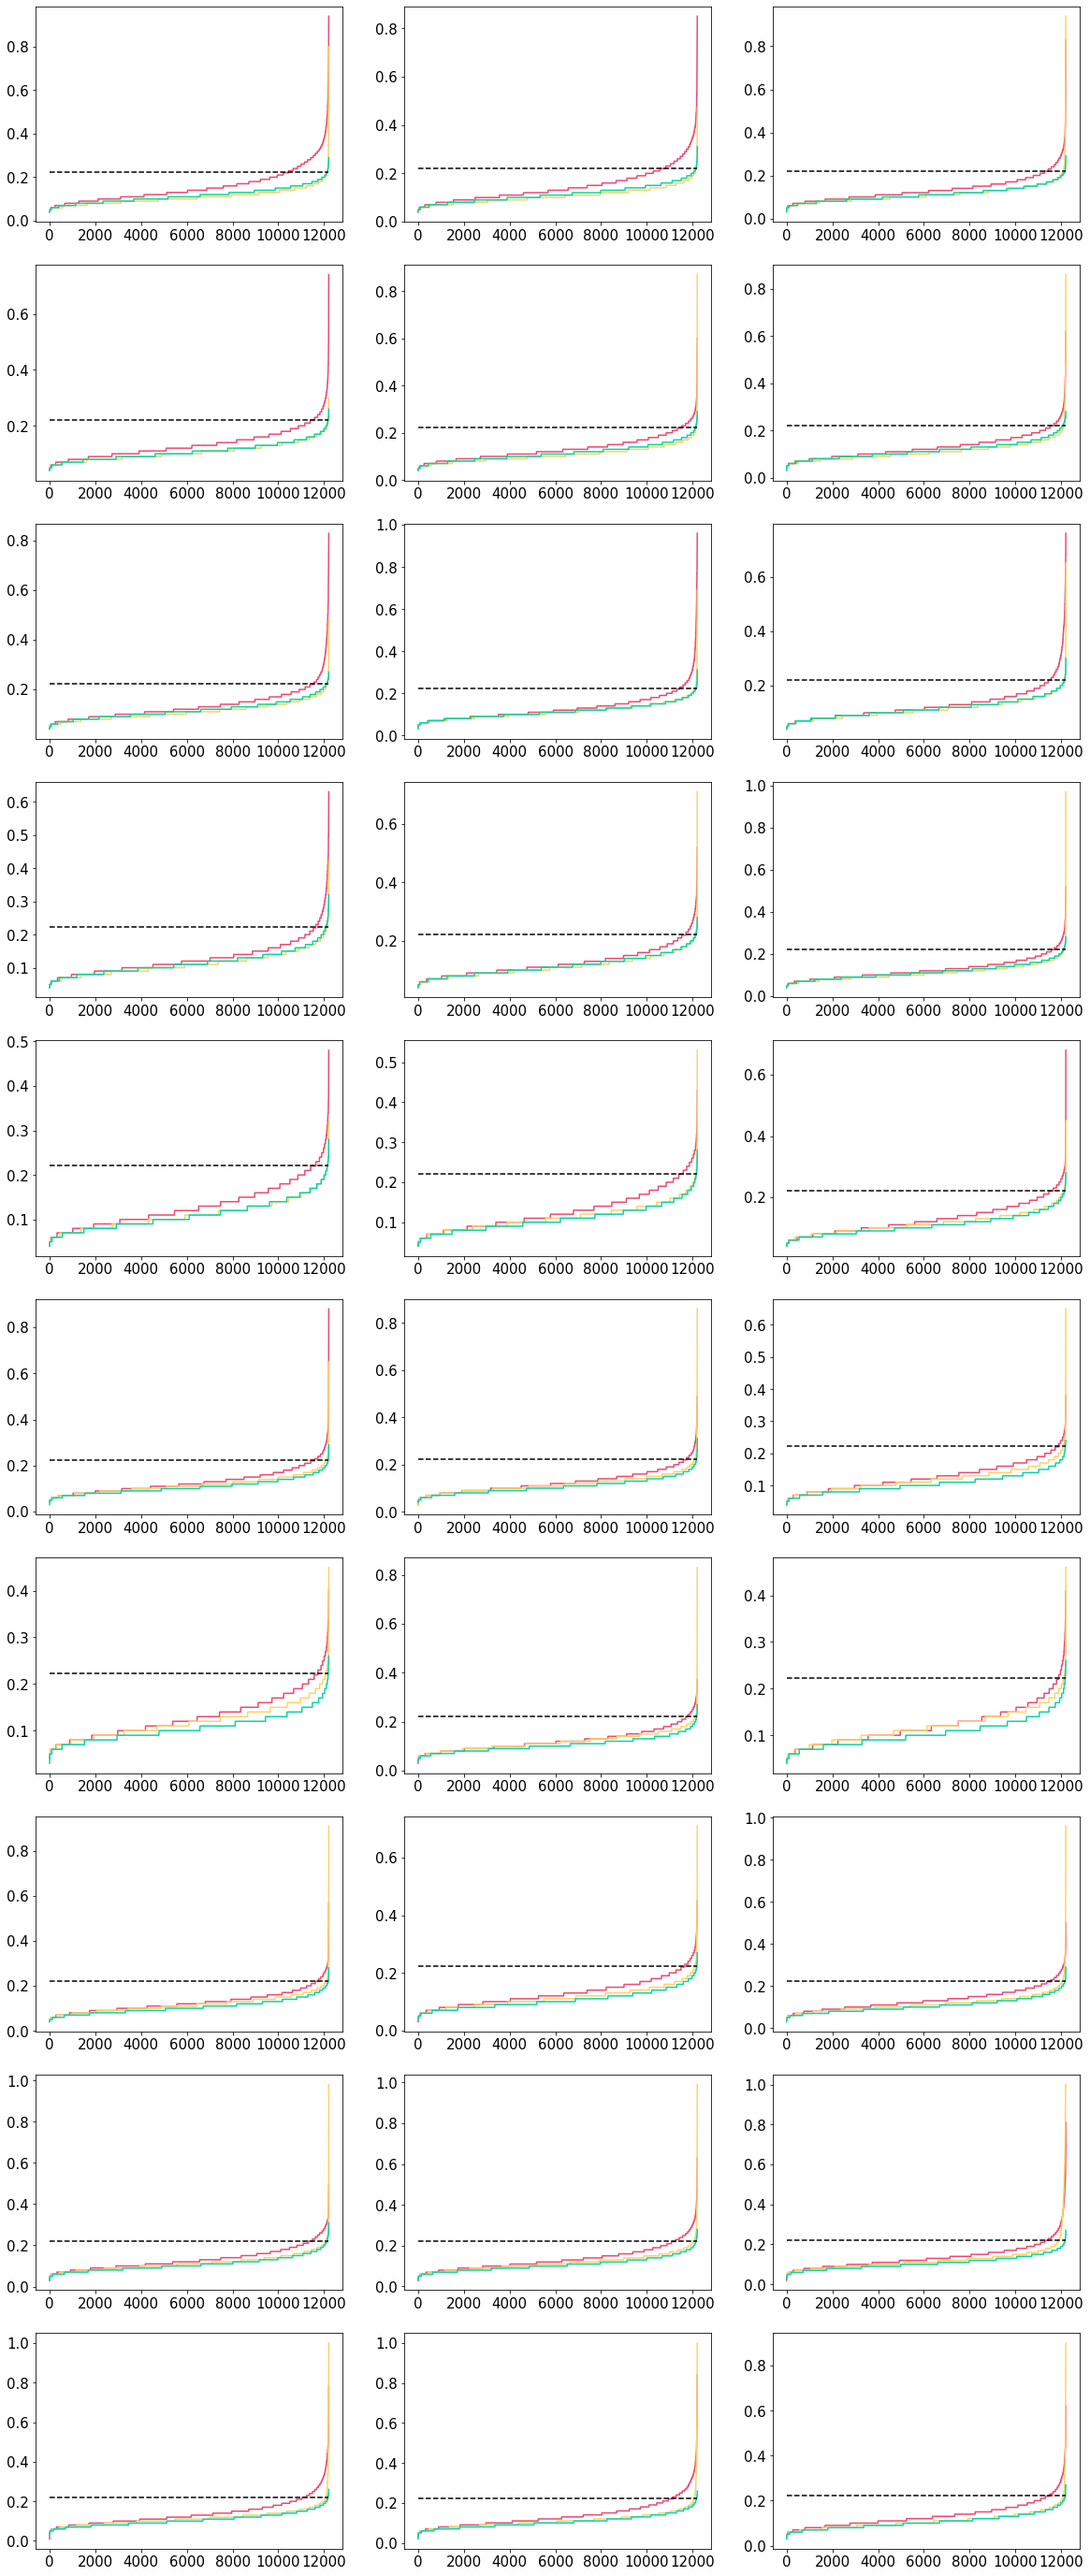

time: 3.26 s


In [9]:
fig, axes = plt.subplots(10, 3, figsize=(20, 50))
axes = axes.flatten()
d_crit = metadata["crit_val"]["KS"]
for i in range(30):
    ax = axes[i]
    nwro = 0
    for j in range(2, -1, -1):
        thesed = cp.sort(d[4][varname][j, i].flatten()).get()
        ax.plot(thesed, color=COLORS[2::-1][j], label=ensembles_in_decisions[j])
    ax.hlines(d_crit, 0, len(thesed) - 1, color="black", ls="--")

# Compare all tests

In [ ]:
from scripts.util import *
allmonths = pd.date_range(TSTA, periods=N_MONTHS, freq="1MS")
%autoreload 2
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "main"
ensembles = metadata["ensembles"][ana]
control = metadata["control"][ana]
notcontrol = metadata["notcontrol"][ana]
ensembles_in_results = metadata["ensembles_in_results"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
f1 = IntProgress(max=2 * len(variablemap))
f2 = IntProgress(max=N_MONTHS)
f3 = IntProgress(max=n_sel)
t1 = HTML(value="Working on : ")
t2 = HTML(value="Last test took : ")
t3 = HTML(value="Last variable took : ")
display(f1, f2, f3, t1, t2, t3)
# d = {}
# decisions = {}
for test in ["T", "KS", "MWU"]:
    # d[test] = {}
    # decisions[test] = {}
    for varname in list(variablemap.keys())[:1]:
        f2.value = 0
        actualfreq = (
            "12h" if (freq == "1D" and variablemap[varname][0][:2] == "12") else freq
        )
        coords = coords_avgdecs(varname, ana, actualfreq, ensembles_in_decisions)
        shape = [len(x) for x in coords.values()]
        decisions[test][varname] = xr.DataArray(
            np.zeros(shape, dtype=bool), coords=coords
        )
        bigname = variablemap[varname][1]
        bigt = timer.time()
        for month in range(101, 102):
            month_ts = allmonths[month]
            here = (decisions[test][varname].time.dt.year == month_ts.year) & (decisions[test][varname].time.dt.month == month_ts.month)
            t1.value = f"Working on {varname}, {month}th month, {test}"
            t = timer.time()
            # darr = loaddarr(
            #     varname, bigname, ensembles, month, ana, big=True, values=False, bs=bs
            # )
            # d[test][varname] = cp.zeros((len(ensembles_in_results), *darr.shape[1:4], n_sel))
            # for s in range(n_sel):
            #     idxs_ref = ran.choice(darr.shape[-1], n_sam['1D'], replace=replace)
            #     b = cp.asarray(darr.sel(ensemble="ref"))[..., idxs_ref]
            #     b = sanitize(b)
            #     to_do, other_args = wraptest(b, test)
            #     for i, ens in enumerate(ensembles_in_results):
            #         idxs = ran.choice(darr.shape[-1], n_sam['1D'], replace=replace)
            #         a = cp.asarray(darr.sel(ensemble=ens))[..., idxs]
            #         a = sanitize(a)
            #         d[test][varname][i, ..., s] = cp.nan_to_num(to_do(a, *other_args), nan=0)
            #     f3.value = s + 1
            avgres = cp.mean(cp.abs(d[test][varname]) > crit_val[test], axis=(2, 3))
            q = cp.quantile(avgres[control], decision_quantile, axis=-1)
            for i, nc in enumerate(notcontrol):
                decisions[test][varname][i, here] = (cp.mean(avgres[nc], axis=-1) > q).get()
            f2.value += 1
            t2.value = f"Last test took {timer.time() - t:.3f}s"
        t3.value = f"Last variable took {timer.time() - bigt:.3f}s"
        f1.value += 1
        cp.cuda.Device().synchronize()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 7), tight_layout=True)
enr = ensembles_in_results["main"]
binstest = {
    'T': np.linspace(0, 4, 41),
    'KS': np.linspace(0.05, 0.4, 71),
    'MWU': np.linspace(cp.amin(d['MWU'][varname]).get(), 4000, 51),
}
for i, (test, bins) in enumerate(binstest.items()):
    for j, ens in enumerate(enr):
        thisd = cp.abs(d[test][varname][j])
        rejected = cp.mean(thisd > crit_val[test]).get()
        label = f'{ens}, {rejected * 100:.2f}% rej'
        counts, bins, _ = axes[i].hist(thisd.flatten().get(), density=True, bins=bins, alpha=0.6, label=label)
    axes[i].vlines([crit_val[test]], 0, np.amax(counts), color='k', ls='--', label=f'{test}_crit')
    axes[i].legend()
    axes[i].set_title(test)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.subplots_adjust(left=0.25)
varname = 't_850hPa'
h = variablemap[varname][0][:3]
test_and_ens = [
    f"{test}_{ens}" for test in ["T", "KS", "MWU"] for ens in ensembles_in_decisions
]
shape = (len(test_and_ens), decisions["T"][varname][:, here].shape[1])
to_plot = xr.DataArray(
    np.empty(shape, dtype=bool),
    coords={"test_and_ens": test_and_ens, "time": month_range(MONTHS[101], h)},
    name=varname,
)
for k, ens in enumerate(ensembles_in_decisions):
    for j, test in enumerate(["T", "KS", "MWU"]):
        to_plot.loc[f"{test}_{ens}", :] = decisions[test][varname][k, here]
ax.pcolormesh(
    to_plot.time,
    np.arange(to_plot.shape[0]),
    to_plot.values,
    cmap=CMAP,
    shading="nearest",
    vmax=1,
    vmin=0,
    rasterized=True,
    linewidth=1,
    edgecolors="white",
)
ax.set_title(varname)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks(np.arange(len(test_and_ens)))
ax.set_yticklabels(test_and_ens, ha="left")

# Sweep roundings


In [10]:
monthidx = 110
MONTHS[monthidx]

'199803'

time: 1.61 ms


In [22]:
varname = 'clct'
test = 'KS'
vmap = metadata["variablemap"][varname]
bigname = vmap[1]
h = vmap[0][:2]
n_sel = metadata["n_sel"]
n_mem = metadata["n_mem"]
replace = metadata["replace"]
bs = metadata["boundary_size"]
freq = '1D'
n_sam = metadata["n_sam"][freq]
crit_val = metadata["crit_val"][freq]
ana = 'comb'
monthidx = 110
darr0 = loaddarr(varname, bigname, ensembles, monthidx, ana, False, bs, True).isel(time=range(10, 20))

eir = metadata["ensembles_in_results"][ana]

time: 1.4 s


In [28]:
roundings = [4, None]

for rounding in roundings:

    ofile = Path(f"{PATHBASE}/results/roundings/{varname}_{rounding}_{MONTHS[monthidx]}.nc")
    if os.path.isfile(ofile):
        continue
    coord_results = {
        'ensemble': eir,
        'time': darr0.time.values,
        'rlat': darr0.rlat.values,
        'rlon': darr0.rlon.values,
        'sel': np.arange(n_sel),
    }
    darr = darr0.values
    
    results = xr.DataArray(
        np.zeros([len(v) for v in coord_results.values()]), 
        coords=coord_results,
    )
    
    b_base = sanitize(cp.asarray(darr[ref[ana], :, :]), rounding)
    for s in range(n_sel):
        print(f's={s+1}/{n_sel}', end='\r')
        idxs_ref = ran.choice(darr.shape[-1], n_sam, replace=replace)
        b = b_base[..., idxs_ref]
        to_do, other_args = wraptest(b, test)
        for n in range(len(notref[ana])):
            idxs = ran.choice(darr.shape[-1], n_sam, replace=replace)
            a = sanitize(cp.asarray(darr[notref[ana][n], :, :][..., idxs]), rounding)
            results[n, ..., s] = (cp.abs(to_do(a, *other_args)) > crit_val[test]).get()
    print('')
    results.to_netcdf(ofile.as_posix())
    glavgres = results.mean(dim=results.dims[2:4]) 
    glavgres.to_netcdf(f"{PATHBASE}/results/roundings/{varname}_{rounding}_{MONTHS[monthidx]}.nc")

s=100/100
time: 2min 19s


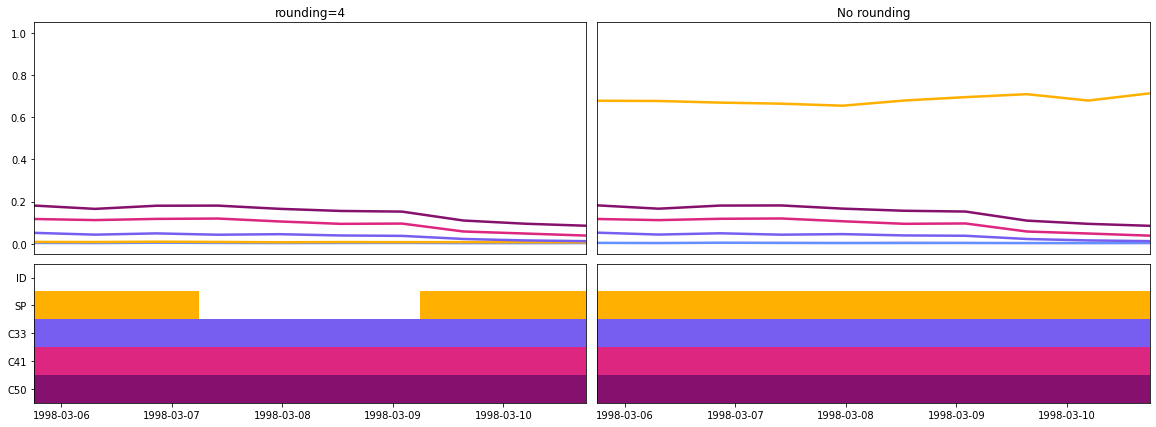

time: 425 ms


In [29]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, BoundaryNorm

roundings = [4, None]
    
gs = GridSpec(2, 2, hspace=0.05, wspace=0.02, height_ratios=[1, 0.6])
fig = plt.figure(figsize=(20, 7))
line_axes = []
pcmesh_axes = []

eid = ensembles_in_decisions['comb']
thesetitles = ['ID', 'SP', 'C33', 'C41', 'C50']

colors = []
for i, ens in enumerate(eid):
    colors.extend(
        LinearSegmentedColormap.from_list(
            'ob',
            ['#FFFFFF', COLORS[i]],
            N=2,
        )(np.linspace(0, 1, 2)).tolist())
    
cmap = ListedColormap(colors)

for i in range(2):
    for j in range(2):
        if i % 2 == 0:
            line_axes.append(fig.add_subplot(gs[i, j]))
        if i % 2 == 1:
            pcmesh_axes.append(fig.add_subplot(gs[i, j]))

for i, (rounding, lax, pax) in enumerate(zip(roundings, line_axes, pcmesh_axes)):
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/roundings/{varname}_{rounding}_{MONTHS[monthidx]}.nc")
    ti = glavgres.time.values
    lq05, lq95 = glavgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
    lines = glavgres.sel(ensemble=eid).mean(dim='sel')
    to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')
    lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
    for t, c, l in zip(thesetitles, COLORS, lines):
        lax.plot(ti, l, color=c, lw=2.5, label=t)
    lax.set_xticks([])
    lax.set_xlim(ti[[0, -1]])
    pax.pcolormesh(
        ti, 
        np.arange(len(to_plot.ensemble))[::-1],
        to_plot.values + np.arange(0, 10, 2)[:, None], 
        shading='nearest',
        cmap=cmap,
        norm=BoundaryNorm(np.arange(11), 11),
        rasterized=True,
        linewidth = 0 if freq in ['1D', '2D'] else 0.5,
        edgecolors="white",
    )
    if rounding is None:
        title = 'No rounding'
    else:
        title = f'{rounding=}'
    lax.set_title(title)
    lax.set_ylim([-0.05, 1.05])
    if i == 0:
        lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
        lax.set_ylabel('')
    else:
        lax.set_yticks([])
        pax.set_yticks([])
# line_axes[0].legend(loc='upper left', ncol=6)
# plt.show()
plt.savefig('Figures/Final/roundings.pdf')

# Final results

In [21]:
test = "KS"
freq = "1D"
ana = "comb"
bs = metadata["boundary_size"]
subset = [
    't_850hPa',
    'u_200hPa',
    'qv_500hPa',
    'fi_500hPa',
    'tot_prec',
    'w_snow',
    'w_so_third',
    'ashfl_s',
    'clct',
    'ps'
]
figtitles = {
    '1': 'This method',
    '2': 'Modified method',
    '3': 'B-H Method',
    'FDR': 'B-H method',
}

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

time: 1.33 ms


In [6]:
from tqdm import tqdm, trange
for varname in tqdm(variablemap):
    bigname = variablemap[varname][1]
    avgres = xr.open_mfdataset(f"{PATHBASE}/results/{ana}_{freq}/avg_{varname}_{test}_*.nc")[HERE].load()
    avgres.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}/avg_{varname}_{test}.nc")
    coords = coords_avgdecs(varname, ana, freq, ensembles_in_decisions[ana], shape=avgres.shape)
    shape = [len(val) for val in coords.values()]
    avgdecs = xr.DataArray(np.zeros(shape), coords=coords)
    for i, ens in enumerate(ensembles_in_decisions[ana]):
        avgdecs.loc[ens, :] = avgres.loc[ens, :, :].mean(dim='sel') > avgres.loc['control', :, :].quantile(decision_quantile, dim='sel')
    avgdecs.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}/avgdecs_{varname}_{test}.nc")

100%|██████████| 47/47 [04:45<00:00,  6.07s/it]

time: 4min 45s


In [4]:
test = 'KS'
ana = 'comb'
freq = '1D'
subset = ['clct', 'clcl', 'clcm', 'clch']
for varname in subset:
    avgres = xr.open_dataarray(f"{PATHBASE}/results/{ana}_{freq}_rounding/avg_{varname}_{test}_v2.nc") 
    coords = coords_avgdecs(varname, ana, freq, ensembles_in_decisions[ana], shape=avgres.shape)
    shape = [len(val) for val in coords.values()]
    avgdecs = xr.DataArray(np.zeros(shape), coords=coords)
    for i, ens in enumerate(ensembles_in_decisions[ana]):
        avgdecs.loc[ens, :] = avgres.loc[ens, :, :].mean(dim='sel') > avgres.loc['control', :, :].quantile(decision_quantile, dim='sel')
    avgdecs.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}_rounding/avgdecs_{varname}_{test}_v2.nc")

time: 14.9 s


/tmp/ipykernel_26400/1845645890.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"Figures/Final/combined_{test}_1_full.pdf")
/tmp/ipykernel_26400/1845645890.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"Figures/Final/combined_{test}_1_full.pdf")
/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/jupyterlab/3.2.8-CrayGNU-21.09-batchspawner-cuda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


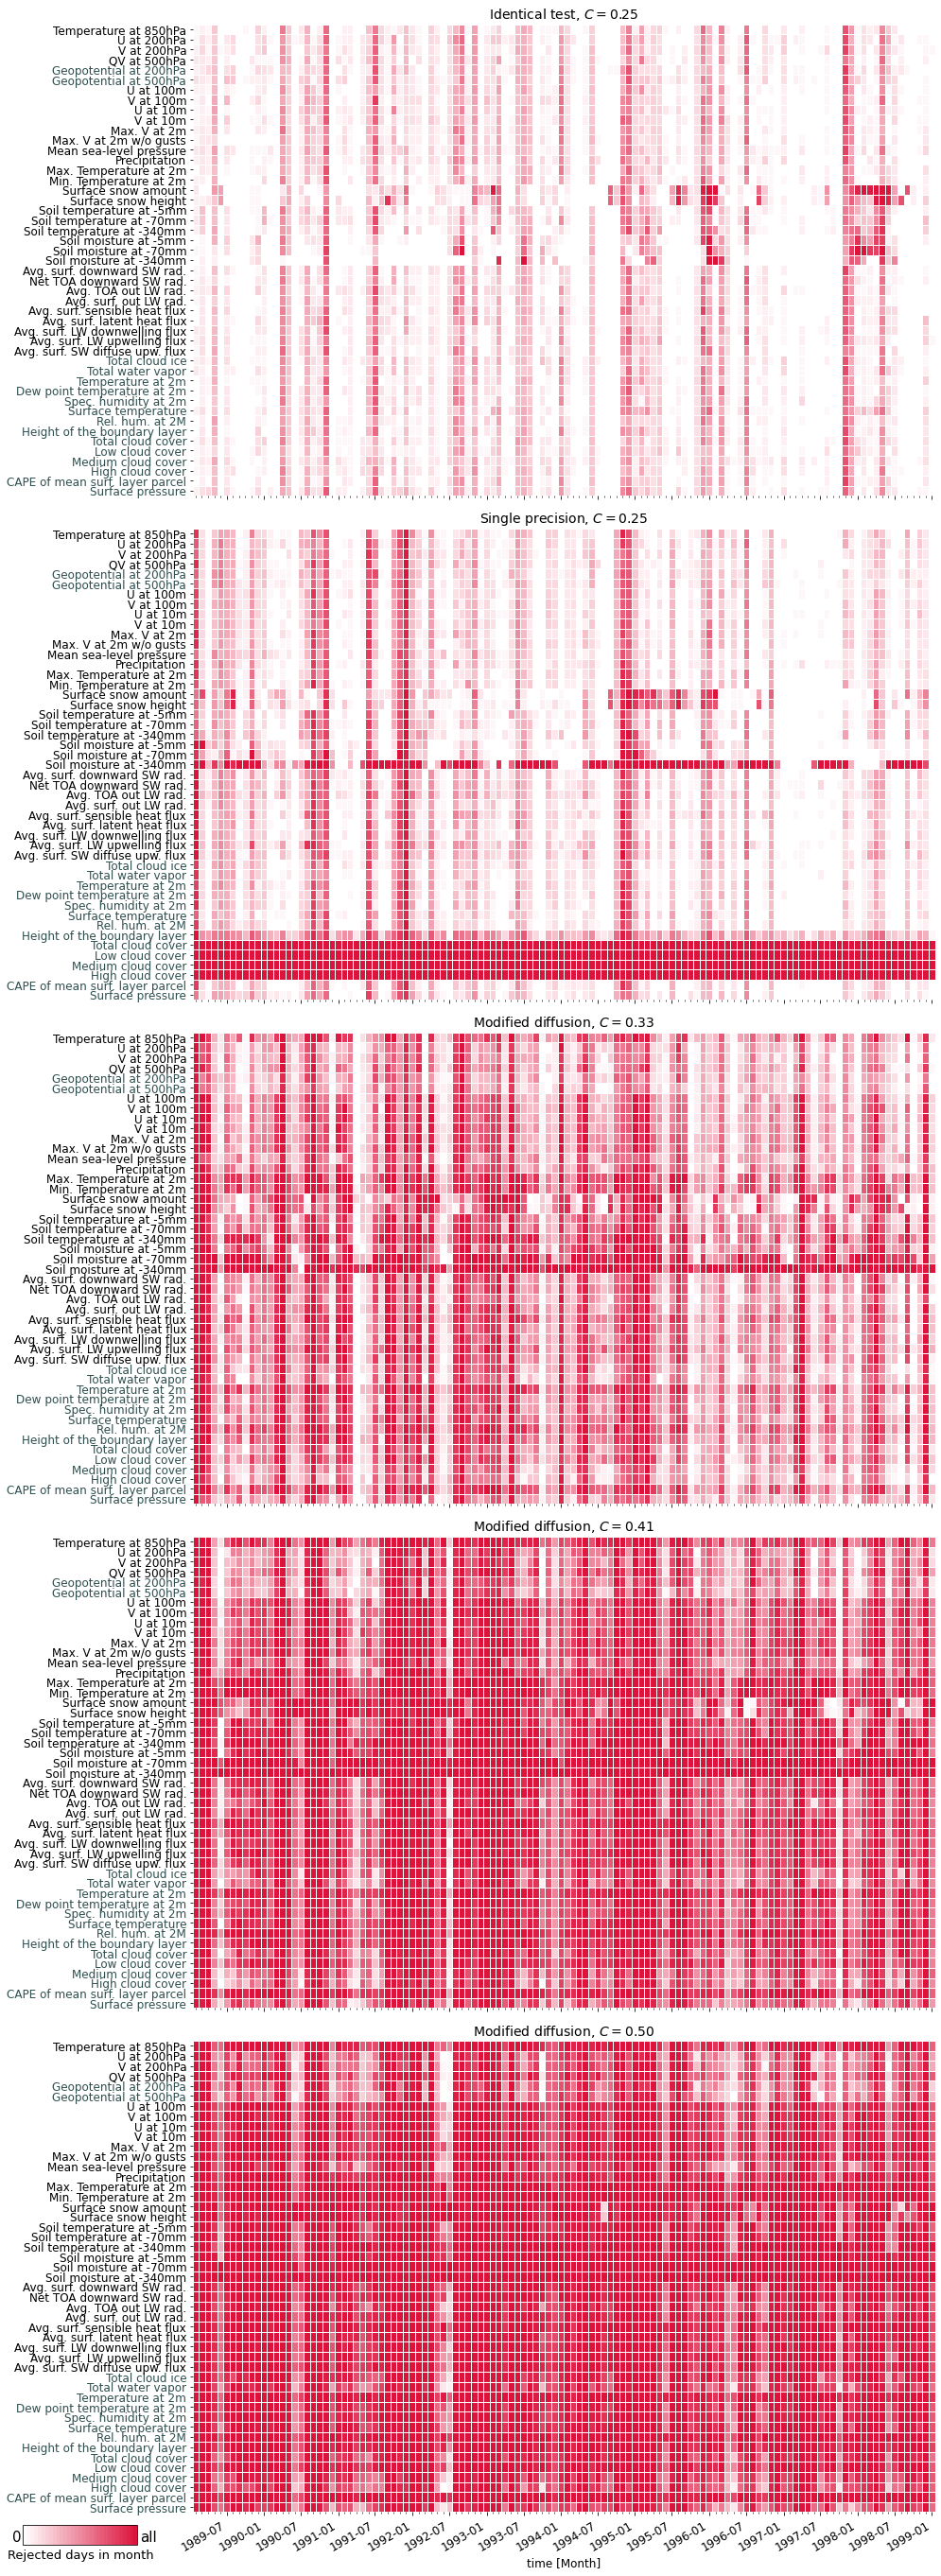

time: 17.1 s


In [5]:
from matplotlib.colors import Normalize
CMAP = LinearSegmentedColormap.from_list(
    'ob',
    [
        '#FFFFFF',
        'crimson',
    ],
    N=31,
)
to_plot = []
subset = [
    't_850hPa',
    'u_200hPa',
    'qv_500hPa',
    'fi_500hPa',
    'tot_prec',
    'w_snow',
    'w_so_third',
    'ashfl_s',
    'clct',
    'ps'
]
subset = None

if subset is not None:
    thisvm = {key: variablemap[key] for key in subset}
else:
    thisvm = variablemap
for i, varname in enumerate(thisvm):
    data = open_avgdecs(varname, ana, freq, test)
    to_plot.append(data.resample(time='1M').mean())
vlabels = [val[-1] for val in thisvm.values()]
xlabel = f"time [Month]"

meandecs = np.empty((len(thisvm), data.shape[0]))

fig, axes = plt.subplots(
    data.shape[0], 1, 
    figsize=(2 * TEXTWIDTH_IN, 3 + 7 * data.shape[0] * len(thisvm) / len(variablemap)), 
    tight_layout=True,
)
#fig.suptitle(figtitles[which])

for k, ax in enumerate(axes):
    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    this_thing = xr.concat(
        [to_plot[i][k, :] for i in range(len(thisvm) - 1, -1, -1)], dim="variable"
    )
    im = xr.plot.pcolormesh(
        this_thing,
        cmap=CMAP,
        ax=ax,
        vmax=1,
        vmin=0,
        rasterized=True,
        linewidth=.5,
        add_colorbar=False,
        edgecolors="white",
        add_labels=False,
    )
    meandecs[:, k] = np.mean(this_thing.values, axis=1)[::-1]
    ax.xaxis_date()
    ax.set_yticks(np.arange(len(vlabels)))
    ax.set_yticklabels(vlabels[::-1], rotation=0)
    labels = ax.get_yticklabels()
    for label, val in zip(reversed(labels), thisvm.values()):
        if val[0][:2] == '12':
            label.set_color('darkslategrey')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    if k < len(axes) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_title(titles[ana][k])
kwargs = dict(cmap=CMAP, norm=Normalize(0, 31))
cax = fig.add_axes([.03, .014 if subset is None else .06, 0.12, 0.008 if subset is None else 0.02])
im = ScalarMappable(**kwargs)
cb = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[])
cb.ax.text(-0.02, 0.4, '0', transform=cb.ax.transAxes, fontsize=15,
    va='center', ha='right')
cb.ax.text(1.02, 0.4, 'all', transform=cb.ax.transAxes, fontsize=15, 
    va='center', ha='left')
cb.ax.set_xlabel('Rejected days in month', fontsize=13)
if subset is None:
    np.savetxt(f"meandecs1_{ana}.csv", meandecs, delimiter=",")
    plt.savefig(f"Figures/Final/combined_{test}_1_full.pdf")
else:
    plt.savefig(f"Figures/Final/combined_{test}_1.pdf")

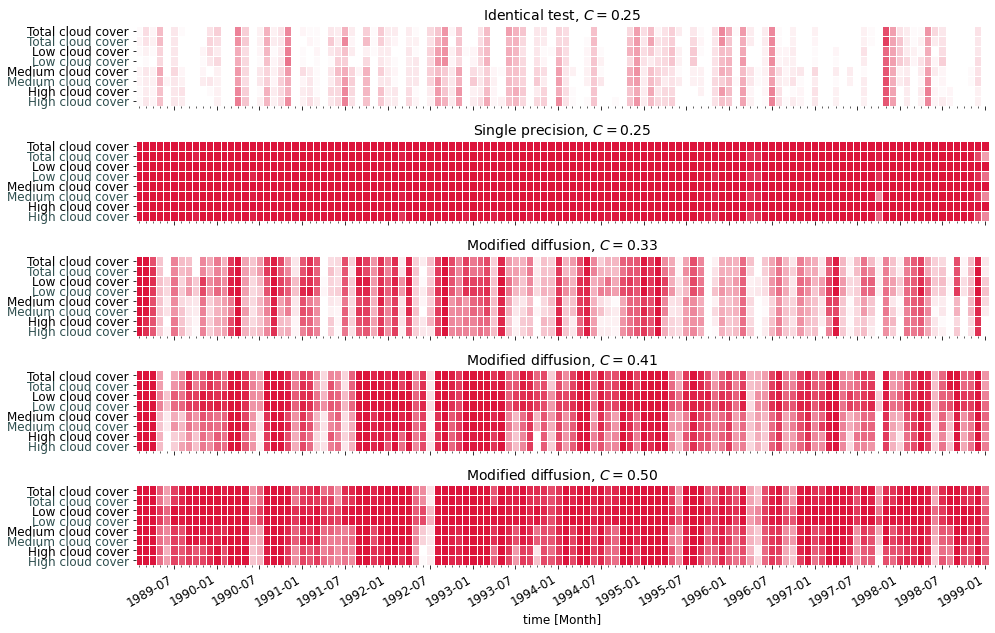

time: 3.26 s


In [16]:
CMAP = LinearSegmentedColormap.from_list(
    'ob',
    [
        '#FFFFFF',
        'crimson',
    ],
    N=50,
)
to_plot = []
subset = ['clct', 'clcl', 'clcm', 'clch']

if subset is not None:
    thisvm = {key: variablemap[key] for key in subset}
else:
    thisvm = variablemap
for i, varname in enumerate(thisvm):
    data = xr.open_dataarray(f"{PATHBASE}/results/{ana}_{freq}/avgdecs_{varname}_{test}.nc")
    to_plot.append(data.resample(time='1M').mean())
    data = xr.open_dataarray(f"{PATHBASE}/results/{ana}_{freq}_rounding/avgdecs_{varname}_{test}_v2.nc")
    to_plot.append(data.resample(time='1M').mean())
vlabels = [val[-1] for val in thisvm.values() for _ in range(2)]
xlabel = f"time [Month]"

fig, axes = plt.subplots(
    data.shape[0], 1, 
    figsize=(2 * TEXTWIDTH_IN, 3 + 2 * 7 * data.shape[0] * len(thisvm) / len(variablemap)), 
    tight_layout=True,
)
#fig.suptitle(figtitles[which])

for k, ax in enumerate(axes):
    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    this_thing = xr.concat(
        [to_plot[i][k, :] for i in range(2 * len(thisvm) - 1, -1, -1)], dim="variable"
    )
    im = xr.plot.pcolormesh(
        this_thing,
        cmap=CMAP,
        ax=ax,
        vmax=1,
        vmin=0,
        rasterized=True,
        linewidth=.5,
        add_colorbar=False,
        edgecolors="white",
        add_labels=False,
    )
    ax.xaxis_date()
    ax.set_yticks(np.arange(len(vlabels)))
    ax.set_yticklabels(vlabels[::-1], rotation=0)
    labels = ax.get_yticklabels()
    for il, label in enumerate(reversed(labels)):
        if il % 2 == 1:
            label.set_color('darkslategrey')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    if k < len(axes) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_title(titles[ana][k])

In [20]:
np.sum(data[1].values)

7157.0

time: 2.14 ms


Identical test, C=0.25 (benchmark)
Single precision, $C=0.25$
Modified diffusion, $C=0.33$
Modified diffusion, $C=0.50$


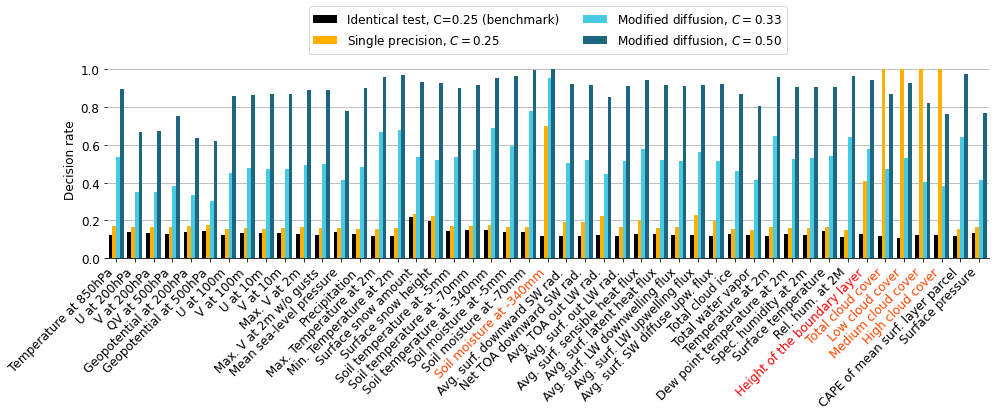

time: 1.36 s


In [36]:
ana = 'comb'
fig, ax = plt.subplots(figsize=(2 * TEXTWIDTH_IN, 6), tight_layout=True)
to_plot = np.loadtxt(f"meandecs1_{ana}.csv", delimiter=',')[:, [0, 1, 2, 4]]
x = np.arange(to_plot.shape[0])
width = 1 / (to_plot.shape[1] + 1)
barcenters = np.linspace(-0.5, 0.5, to_plot.shape[1] + 2)[1:-1]

for key in ['left', 'right', 'top']:
    ax.spines[key].set_visible(False)
ax.grid(True, axis="y", zorder=-10)
thesetitles = [titles['comb'][i] for i in (0, 1, 2, 4)]
thesetitles[0] = "Identical test, C=0.25 (benchmark)"
colors = COLORS
colors = ['black', '#FFB000', "#48cae4", "#1c6682"]
for j in range(to_plot.shape[1]):
    ax.bar(
        x + barcenters[j],
        to_plot[:, j],
        width,
        color=colors[j],
        label=thesetitles[j],
        zorder=10,
    )
    print(thesetitles[j])
ax.set_ylim([0, 1.05])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("Decision rate")
ax.set_xlim([-0.5, len(x) - 0.5])

ax.legend(ncol=to_plot.shape[1] // 2, loc='upper center', bbox_to_anchor=(0.5, 1.3))
if subset is not None:
    thisvm = {key: variablemap[key] for key in subset}
else:
    thisvm = variablemap
ax.set_xticks(np.arange(len(thisvm)), labels=[None] * len(thisvm))
    
vlabels = [val[-1] for val in variablemap.values()]
fig.canvas.draw()
ax.set_xticks(np.arange(len(vlabels)), labels=vlabels, rotation=45, ha="right")
# _ = ax.set_xticklabels()
for label, varname in zip(ax.get_xticklabels(), list(variablemap.keys())):
    if varname == 'hpbl':
        label.set_color('red')
    if varname in ['clcl', 'clcm', 'clch', 'clct', 'w_so_fifth']:
        label.set_color('orangered')
# for label, val in zip(ax.get_xticklabels(), variablemap.values()):
#     if val[0][:2] == '12':
#         label.set_color('darkslategrey')
plt.savefig('Figures/Final/comp_horiz_for_poster.pdf')

## Comparisons

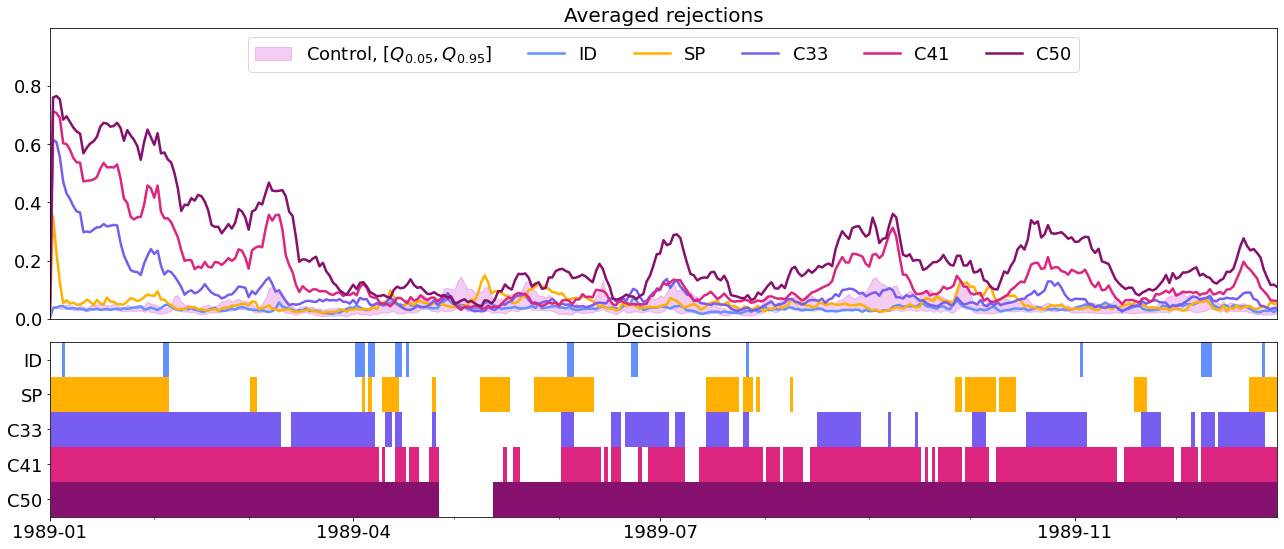

time: 606 ms


In [10]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

varname = 'asob_s'
ana = 'comb'
test = 'KS'
freq = '1D'
eid = ensembles_in_decisions['comb']
# thesetitles = titles['comb']
thesetitles = ['ID', 'SP', 'C33', 'C41', 'C50']
avgres = xr.open_dataarray(f"{PATHBASE}/results/{ana}_{freq}/avg_{varname}_{test}.nc")
avgres = avgres.isel(time=avgres.time.dt.year<1990)
ti = avgres.time.values
lq05, lq95 = avgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
lines = avgres.sel(ensemble=eid).mean(dim='sel')
to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')

gs = GridSpec(2, 1, hspace=0.1, wspace=0.02, height_ratios=[1, 0.6])
fig = plt.figure(figsize=(22, 9))
lax = fig.add_subplot(gs[0])
pax = fig.add_subplot(gs[1])
colors = COLORS

lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
for t, c, l in zip(thesetitles, colors, lines):
    lax.plot(ti, l, color=c, lw=2.5, label=t)
lax.set_xticks([])
lax.set_xlim(ti[[0, -1]])
colors = []
for i, ens in enumerate(eid):
    colors.extend(
        LinearSegmentedColormap.from_list(
            'ob',
            ['#FFFFFF', COLORS[i]],
            N=2,
        )(np.linspace(0, 1, 2)).tolist())
cmap = ListedColormap(colors)
pax.pcolormesh(
    ti, 
    np.arange(len(to_plot.ensemble))[::-1],
    to_plot.values + np.arange(0, 10, 2)[:, None], 
    shading='nearest',
    cmap=cmap,
    norm=BoundaryNorm(np.arange(11), 11),
    rasterized=True,
    linewidth = 0 if freq in ['1D', '2D'] else 0.5,
    edgecolors="white",
)
lax.set_ylim([0, 1.0])
lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
lax.set_ylabel('')
#pax.xaxis.set_major_locator(mdates.MonthLocator((1, 3, 5, 7, 9, 11)))
pax.xaxis.set_major_locator(mdates.MonthLocator((1, 4, 7, 11)))
pax.xaxis.set_minor_locator(mdates.MonthLocator())
lax.legend(loc='upper center', ncol=6, fontsize=18)
lax.set_title('Averaged rejections')
pax.set_title('Decisions')
pax.set_xlim(6940, 7304)
plt.savefig(f'Figures/Final/example_final_{varname}.pdf')

# Vs FDR

In [12]:
test = "KS"
freq = "1D"
bs = metadata["boundary_size"]

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

time: 1.14 ms


In [8]:
to_plot = np.zeros((len(variablemap), 6))
for i, varname in enumerate(variablemap):
    dec_own = xr.open_dataarray(f'{PATHBASE}/results/comb_1D/avgdecs_{varname}_KS.nc').sel(ensemble=['control2', 'sp', 'diff'])
    dec_fdr = xr.open_dataarray(f'{PATHBASE}/results/main_1D/FDR_decisions_KS_{varname}.nc')
    to_plot[i, :3] = dec_own.mean(dim='time').values
    to_plot[i, 3:] = dec_fdr.mean(dim='time').values
np.savetxt('fdr_vs_own.csv', to_plot, delimiter=',')

time: 2.23 s


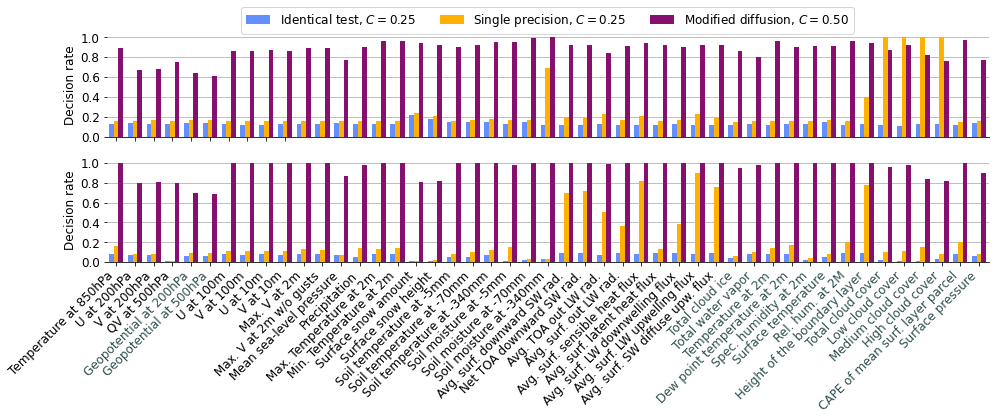

time: 1.68 s


In [11]:
fig, axes = plt.subplots(2, figsize=(2 * TEXTWIDTH_IN, 6), tight_layout=True)
fig.subplots_adjust(hspace=0.05)
to_plot = np.loadtxt('fdr_vs_own.csv', delimiter=',')
x = np.arange(to_plot.shape[0])
ana = 'main'
width = 1 / (n_ens[ana] - 1)
barcenters = np.linspace(-0.5, 0.5, n_ens[ana])[1:-1]

for ax in axes:
    for key in ['left', 'right', 'top']:
        ax.spines[key].set_visible(False)
    ax.grid(True, axis="y", zorder=-10)
thesetitles = titles['main']
k = [0, 1, 4]
for j in range(3):
    axes[0].bar(
        x + barcenters[j],
        to_plot[:, j],
        width,
        color=COLORS[k[j]],
        label=thesetitles[j],
        zorder=10,
    )
    axes[1].bar(
        x + barcenters[j],
        to_plot[:, 3 + j],
        width,
        color=COLORS[k[j]],
        label=thesetitles[j],
        zorder=10,
    )

for ax in axes:
    ax.set_ylim([0, 1.05])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylabel("Decision rate")
    ax.set_xlim([-0.5, len(x) - 0.5])

axes[0].legend(ncol=(n_ens[ana] - 1), loc='upper center', bbox_to_anchor=(0.5, 1.3))
if subset is not None:
    thisvm = {key: variablemap[key] for key in subset}
axes[0].set_xticks(np.arange(len(thisvm)), labels=[None] * len(thisvm))
    
vlabels = [val[-1] for val in variablemap.values()]
fig.canvas.draw()
axes[1].set_xticks(np.arange(len(vlabels)))
_ = axes[1].set_xticklabels(vlabels, rotation=45, ha="right")
for label, val in zip(axes[1].get_xticklabels(), variablemap.values()):
    if val[0][:2] == '12':
        label.set_color('darkslategrey')
plt.savefig('Figures/Final/comp_fdr.pdf')

# Oversampling

## What's oversampling in this context ?

The following paragraph considers you're already familiar with Christian's methodology, this discusses a small change that can be done to it.  
With this technique, we consider as indistinguishable the results of all days from a given period (two days, a week or a month, called the oversampling period), which can be justified for most variables from a high time-autocorrelation after up to a month (see later). When drawing subsamples in the original method, we always draw a day from an ensemble and the same day in another. Here, we increase the size of the pool to include all days within the oversampling period, at the cost of a more coarse-grained time-axis (only one point per oversampling period). This much larger pool allows for a larger sample size for each period, which has been shown to increase the sensitivity of the test when all the data is actually independant. We will show that even with this artificial increase, we also observe an increase in sensitivity.

This effectively changes the data shape from (n_days, n_mem) to (n_days / per, n_mem * per), where n_days is 3650, n_mem is 20 and per (confusingly called "freq" in the code, sorry about that) is the oversampling period, typically a month. We also change the subsampling frequency from 7 to, for example for per='2D', 14. With these changes the tests are performed using the same code as for the regular technique.

## Oversample def

## Step one : Compute rejections

In [21]:
from pathlib import Path

varname = 't_850hPa'
ana = 'comb'
test = 'KS'
vmap = metadata["variablemap"][varname]
bigname = vmap[1]
h = vmap[0][:2]
ensembles = metadata["ensembles"][ana]
ensembles_in_results = metadata["ensembles_in_results"][ana]
ref = metadata["ref"][ana]
notref = metadata["notref"][ana]
n_sel = metadata["n_sel"]
n_mem = metadata["n_mem"]
replace = metadata["replace"]
bs = metadata["boundary_size"]
rounding = metadata["rounding"]

dims, coords = get_grid(varname, bs, full=True)
fulldims = dict(
    ensemble=ensembles_in_results, 
    time=month_range(MONTHS[0], freq), 
    **dims,
    sel=np.arange(n_sel)
)
darr0 = loaddarr(varname, bigname, ensembles, np.arange(108, 120), ana, False, bs, load=True)

time: 24.5 s


In [22]:
for freq in ['1w', '2w', '2D', '5D', '1MS', '3MS']:
    print(freq)
    n_sam = metadata["n_sam"][freq]
    crit_val = metadata["crit_val"][freq]

    glavgres = [] # Compute spatial averages on the fly for Christian's method

    ofile = Path(f"{PATHBASE}/results/{ana}_{freq}/{varname}_{test}_1998.nc")
    ofile.parent.mkdir(parents=True, exist_ok=True)
    if os.path.isfile(ofile):
        continue
    darr = oversample(darr0, freq)
    fulldims['time'] = darr.time
    darr = darr.values
    results = np.zeros((len(notref), *darr.shape[1:4], n_sel))
    
    results = xr.DataArray(
        results, 
        coords=fulldims,
    )
    csize = 10
    for i in range(0, darr.shape[2], csize):
        end = min(darr.shape[2], i + csize)
        b_base = sanitize(cp.asarray(darr[ref, :, i:end]), rounding)
        print(i, ' :', end=' ')
        for s in range(n_sel):
            print(s, end=' ')
            idxs_ref = ran.choice(darr.shape[-1], n_sam, replace=replace)
            b = b_base[..., idxs_ref]
            rej = cp.empty((len(notref), darr.shape[1], darr.shape[3]), dtype=bool)
            to_do, other_args = wraptest(b, test)
            for n in range(len(notref)):
                # Draw test
                idxs = ran.choice(darr.shape[-1], n_sam, replace=replace)
                a = sanitize(cp.asarray(darr[notref[n], :, i:end][..., idxs]), rounding)
                results[n, :, i:end, :, s] = (cp.abs(to_do(a, *other_args)) > crit_val[test]).get()
        print('')
    glavgres.append(results.mean(dim=darr0.dims[2:4]))
    ofile.parent.mkdir(parents=True, exist_ok=True)
    results.to_netcdf(ofile.as_posix())

1w
0  : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

KeyboardInterrupt: 

time: 3min 40s


### Add in C33 and C41 actually

In [3]:
from pathlib import Path

varname = 't_850hPa'
ana = 'sensi'
test = 'KS'
vmap = metadata["variablemap"][varname]
bigname = vmap[1]
h = vmap[0][:2]
ensembles = metadata["ensembles"][ana]
ensembles_in_results = metadata["ensembles_in_results"][ana]
ref = metadata["ref"][ana]
notref = metadata["notref"][ana]
n_sel = metadata["n_sel"]
n_mem = metadata["n_mem"]
replace = metadata["replace"]
bs = metadata["boundary_size"]
rounding = metadata["rounding"]

dims, coords = get_grid(varname, bs, full=True)
fulldims = dict(
    ensemble=ensembles_in_results, 
    time=month_range(MONTHS[0], freq), 
    **dims,
    sel=np.arange(n_sel)
)
if freq == '1D' and shape[1] > 31:  # check if 12h
    freq = '12h'
darr0 = loaddarr(varname, bigname, ensembles, np.arange(108, 120), ana, True, False, bs, load=True).sel(ensemble=['ref', 'C33', 'C41'])

time: 29.5 s


In [ ]:
notref = [1, 2]
for freq in ['1w', '2w', '2D', '5D', '1MS', '3MS']:
    print(freq)
    n_sam = metadata["n_sam"][freq]
    crit_val = metadata["crit_val"][freq]

    glavgres = [] # Compute spatial averages on the fly for Christian's method

    ifile = Path(f"{PATHBASE}/results/main_{freq}/{varname}_{test}_1998.nc")
    ofile = Path(f"{PATHBASE}/results/sensi_{freq}/{varname}_{test}_1998.nc")
    if os.path.isfile(ofile):
        continue
    results_main = xr.open_dataarray(ifile.as_posix())
    coords = {key: value for key, value in results_main.coords.items()}
    coords['ensemble'] = ['C33', 'C41']
    shape = [len(c) for c in coords.values()]
    results = xr.DataArray(np.zeros(shape), coords=coords)
    darr = oversample(darr0, freq)
    csize = 10
    for i in range(0, darr.shape[2], csize):
        end = min(darr.shape[2], i + csize)
        b_base = sanitize(cp.asarray(darr[0, :, i:end]), rounding)
        print(i, ' :', end=' ')
        for s in range(n_sel):
            print(s, end=' ')
            idxs_ref = ran.choice(darr.shape[-1], n_sam, replace=replace)
            b = b_base[..., idxs_ref]
            rej = cp.empty((len(notref), darr.shape[1], darr.shape[3]), dtype=bool)
            to_do, other_args = wraptest(b, test)
            for n in range(len(notref)):
                # Draw test
                idxs = ran.choice(darr.shape[-1], n_sam, replace=replace)
                a = sanitize(cp.asarray(darr[notref[n], :, i:end][..., idxs]), rounding)
                results[n, :, i:end, :, s] = (cp.abs(to_do(a, *other_args)) > crit_val[test]).get()
        print('')
    glavgres.append(results.mean(dim=darr0.dims[2:4]))
    ofile.parent.mkdir(parents=True, exist_ok=True)
    results.to_netcdf(ofile.as_posix())

### Combine

In [8]:
for freq in ['1D', '2D', '5D', '1w', '2w', '1MS', '3MS']:
    print(freq)
    ires = []
    n_sam = metadata["n_sam"][freq]
    crit_val = metadata["crit_val"][freq]
    
    ofile = Path(f"{PATHBASE}/results/comb_{freq}/{varname}_{test}_1998.nc")
    ofile_avgdecs = Path(f"{PATHBASE}/results/comb_{freq}/avg_{varname}_{test}_1998.nc")
    ofile.parent.mkdir(parents=True, exist_ok=True)
    if os.path.isfile(ofile):
        continue
    
    for thisana in ['main', 'sensi']:
        if freq == '1D':
            ifiles = [
                f"{PATHBASE}/results/{thisana}_{freq}/{varname}_{test}_{month}.nc" 
                for month in MONTHS[108:]
            ]
            ires.append(xr.open_mfdataset(ifiles)[HERE])
            if thisana == 'sensi':
                ires[-1] = ires[-1].sel(ensemble=['C33', 'C41'])
        else:
            ifile = Path(f"{PATHBASE}/results/{thisana}_{freq}/{varname}_{test}_1998.nc")
            ires.append(xr.open_dataarray(ifile.as_posix()))
    results = xr.concat(ires, dim='ensemble')
    glavgres = results.mean(dim=results.dims[2:4])
    results.to_netcdf(ofile.as_posix())
    glavgres.to_netcdf(ofile_avgdecs.as_posix())

1D
2D
5D
1w
2w
1MS
3MS
time: 2min 23s


## Step two : compute decisions

In [9]:
control = 0
notcontrol = [1, 2, 4, 5, 3]
decision_quantile = metadata["decision_quantile"]
ensembles_in_decisions = ['control2', 'sp', 'C33', 'C41', 'diff']
freqs = ['1D', '2D', '5D', '1w', '2w', '1MS', '3MS']
avgdecs = []
for i, freq in enumerate(freqs):
    print(freq)
    n_sam = metadata["n_sam"][freq]
    crit_val = metadata["crit_val"][freq]
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/comb_{freq}/avg_{varname}_{test}_1998.nc")
    coords = {
        'ensemble': ensembles_in_decisions,
        'time': glavgres.time,
    }
    glavgres = cp.asarray(glavgres.values)
    avgdecs.append(xr.DataArray(np.empty([len(val) for val in coords.values()], dtype=bool), coords=coords))
    for k, j in enumerate(notcontrol):
        avgdecs[i][k, :] = (cp.mean(glavgres[j], axis=-1) > cp.quantile(glavgres[control], decision_quantile, axis=-1)).get()
    # break

1D
2D
5D
1w
2w
1MS
3MS
time: 4.97 s


In [10]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

time: 1.33 ms


1D
2D
1w
2w
1MS
3MS


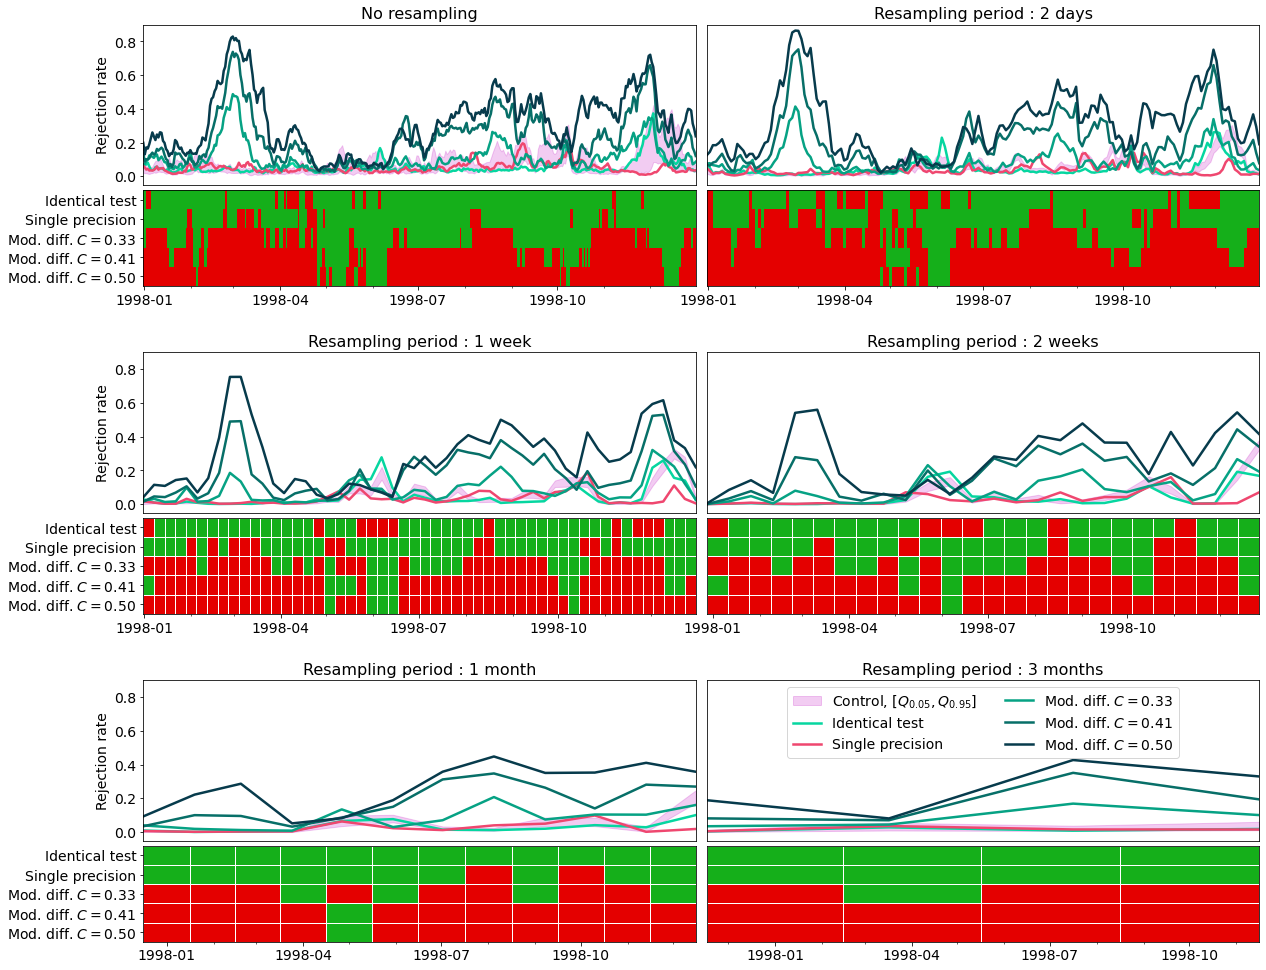

time: 1.92 s


In [14]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
freqs = ['1D', '2D', '1w', '2w', '1MS', '3MS']
gs = GridSpec(9, 2, hspace=0.05, wspace=0.02, height_ratios=[1, 0.6, 0.35] * 3)
fig = plt.figure(figsize=(20, 18))
line_axes = []
pcmesh_axes = []
C_to_B = LinearSegmentedColormap.from_list("bdb", [COLORS[2], COLORS[4]], N=4)(np.linspace(0, 1, 4))
colors = [C_to_B[0], COLORS[0], C_to_B[1], C_to_B[2], C_to_B[3]]

thesetitles = [
    'Identical test', 'Single precision', 
    'Mod. diff. $C=0.33$', 'Mod. diff. $C=0.41$', 'Mod. diff. $C=0.50$'
]
ensembles_in_decisions = ['control2', 'sp', 'C33', 'C41', 'diff']

for i in range(9):
    for j in range(2):
        if i % 3 == 2:
            fig.add_subplot(gs[i, j]).set_visible(False)
        if i % 3 == 0:
            line_axes.append(fig.add_subplot(gs[i, j]))
        if i % 3 == 1:
            pcmesh_axes.append(fig.add_subplot(gs[i, j]))
nicer_unit = {
    'D': 'day',
    'w': 'week',
    'M': 'month',
}
for i, (freq, lax, pax) in enumerate(zip(freqs, line_axes, pcmesh_axes)):
    print(freq)
    n_sam = metadata["n_sam"][freq]
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/comb_{freq}/avg_{varname}_{test}_1998.nc")
    ti = glavgres.time.values
    mask = (ti >= np.datetime64('1998-01-01')) & (ti < np.datetime64('1999-01-01'))
    glavgres = glavgres[:, mask, ...]
    ti = glavgres.time.values
    lq05, lq95 = glavgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
    lines = glavgres.sel(ensemble=ensembles_in_decisions).mean(dim='sel')
    to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')
    lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
    for t, c, l in zip(thesetitles, colors, lines):
        lax.plot(ti, l, color=c, lw=2.5, label=t)
    lax.set_xticks([])
    lax.set_xlim(ti[[0, -1]])
    pax.pcolormesh(
        ti, 
        np.arange(len(to_plot.ensemble))[::-1],
        to_plot.values, 
        shading='nearest',
        cmap=CMAP,
        vmax=1,
        vmin=0,
        rasterized=True,
        linewidth=0 if freq in ['1D', '2D'] else 0.5,
        edgecolors="white",
    )
    if freq == '1D':
        title = 'No resampling'
    else:
        title = f'Resampling period : {freq[0]} {nicer_unit[freq[1]]}{"s" if int(freq[0]) > 1 else ""}'
    lax.set_title(title)
    lax.set_ylim([-0.05, 0.9])
    if i % 2 == 0:
        lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
        pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
        lax.set_ylabel('Rejection rate')
    else:
        lax.set_yticks([])
        pax.set_yticks([])
    pax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    pax.xaxis.set_minor_locator(mdates.MonthLocator())
lax.legend(loc='upper center', ncol=2)
# plt.show()
plt.savefig('Figures/Final/oversampling.pdf')

# Spatial coarsening

In [5]:
varname = 't_850hPa'
test = 'KS'
vmap = metadata["variablemap"][varname]
bigname = vmap[1]
h = vmap[0][:2]
n_sel = metadata["n_sel"]
n_mem = metadata["n_mem"]
replace = metadata["replace"]
bs = metadata["boundary_size"]
rounding = metadata["rounding"]
freq = '1D'
n_sam = metadata["n_sam"][freq]
crit_val = metadata["crit_val"][freq]
ana = 'comb'

darr0 = loaddarr(varname, bigname, ensembles, np.arange(108, 120), ana, False, bs, True)

# notref = notref[ana]
# ref = ref[ana]
# eir = ensembles_in_results[ana]

time: 25.8 s


In [6]:
c_facs_x = [3, 6, 27, 54, 109]
c_facs_y = [3, 7, 28, 56, 112]
for fac_x, fac_y in zip(c_facs_x, c_facs_y):
    print(fac_x, fac_y)

    ifile = Path(f"{PATHBASE}/results/grid_coarsening/avg_{varname}_{fac_x}_{fac_y}_1998.nc")
    ofile = Path(f"{PATHBASE}/results/grid_coarsening/avg_{varname}_{fac_x}_{fac_y}_1998_v2.nc")

    if os.path.isfile(ofile):
        continue
    darr = darr0.coarsen({"rlat": fac_x, "rlon": fac_y}, boundary="trim").mean()
    darr = darr.values
    
    results = xr.open_dataarray(ifile.as_posix())
    
    b_base = sanitize(cp.asarray(darr[ref['comb'], :, :]), rounding)
    for s in range(n_sel):
        print(f's={s+1}/{n_sel}', end='\r')
        idxs_ref = ran.choice(darr.shape[-1], n_sam, replace=replace)
        b = b_base[..., idxs_ref]
        to_do, other_args = wraptest(b, test)
        idxs = ran.choice(darr.shape[-1], n_sam, replace=replace)
        a = sanitize(cp.asarray(darr[notref['comb'][2], :, :][..., idxs]), rounding)
        results[2, :, s] = cp.mean(cp.abs(to_do(a, *other_args)) > crit_val[test], axis=(1, 2)).get()
    print('')
    results.to_netcdf(ofile.as_posix())

3 3
s=100/100
6 7
s=100/100
27 28
s=100/100
54 56
s=100/100
109 112
s=100/100
time: 3min 22s


In [7]:
da = xr.open_dataarray(f"{PATHBASE}/results/comb_1D/avg_{varname}_{test}.nc")
da = da.sel(time=da.time.dt.year==1998)
da.to_netcdf(f"{PATHBASE}/results/grid_coarsening/avg_{varname}_1_1_1998_v2.nc")
da.to_netcdf(f"{PATHBASE}/results/time_coarsening/avg_{varname}_1D_1998_v2.nc")

time: 29.8 ms


1 1
3 3
6 7
27 28
54 56
109 112


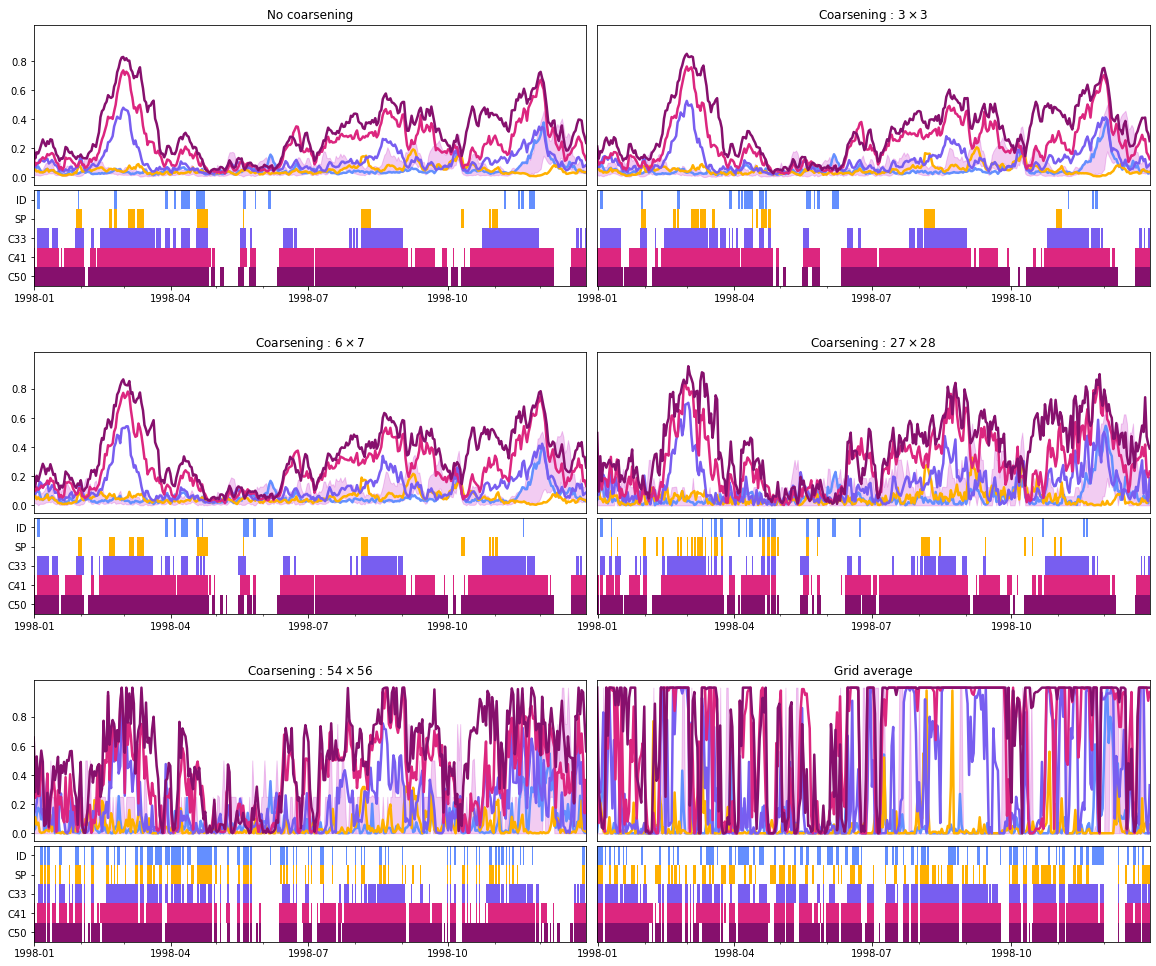

time: 2.27 s


In [10]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure

c_facs_x = [1, 3, 6, 27, 54, 109]
c_facs_y = [1, 3, 7, 28, 56, 112]
    
gs = GridSpec(9, 2, hspace=0.05, wspace=0.02, height_ratios=[1, 0.6, 0.35] * 3)
fig = plt.figure(figsize=(20, 18))
line_axes = []
pcmesh_axes = []

eid = ensembles_in_decisions['comb']
thesetitles = ['ID', 'SP', 'C33', 'C41', 'C50']

colors = []
for i, ens in enumerate(eid):
    colors.extend(
        LinearSegmentedColormap.from_list(
            'ob',
            ['#FFFFFF', COLORS[i]],
            N=2,
        )(np.linspace(0, 1, 2)).tolist())
cmap = ListedColormap(colors)

for i in range(9):
    for j in range(2):
        if i % 3 == 2:
            fig.add_subplot(gs[i, j]).set_visible(False)
        if i % 3 == 0:
            line_axes.append(fig.add_subplot(gs[i, j]))
        if i % 3 == 1:
            pcmesh_axes.append(fig.add_subplot(gs[i, j]))

for i, (fac_x, fac_y, lax, pax) in enumerate(zip(c_facs_x, c_facs_y, line_axes, pcmesh_axes)):
    print(fac_x, fac_y)
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/grid_coarsening/avg_{varname}_{fac_x}_{fac_y}_1998_v2.nc")
    ti = glavgres.time.values
    lq05, lq95 = glavgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
    lines = glavgres.sel(ensemble=eid).mean(dim='sel')
    to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')
    lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
    for t, c, l in zip(thesetitles, COLORS, lines):
        lax.plot(ti, l, color=c, lw=2.5, label=t)
    lax.set_xticks([])
    lax.set_xlim(ti[[0, -1]])
    pax.pcolormesh(
        ti, 
        np.arange(len(to_plot.ensemble))[::-1],
        to_plot.values + np.arange(0, 10, 2)[:, None], 
        shading='nearest',
        cmap=cmap,
        norm=BoundaryNorm(np.arange(11), 11),
        rasterized=True,
        linewidth = 0 if freq in ['1D', '2D'] else 0.5,
        edgecolors="white",
    )
    if fac_x == 1:
        title = 'No coarsening'
    elif fac_x == 109:
        title = 'Grid average'
    else:
        title = f'Coarsening : ${fac_x}' + r'\times' + f'{fac_y}$'
    lax.set_title(title)
    lax.set_ylim([-0.05, 1.05])
    if i % 2 == 0:
        lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
        pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
        lax.set_ylabel('')
    else:
        lax.set_yticks([])
        pax.set_yticks([])
    pax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    pax.xaxis.set_minor_locator(mdates.MonthLocator())
# line_axes[0].legend(loc='upper left', ncol=6)
# plt.show()
plt.savefig('Figures/Final/coarsening.pdf')

# Time coarsening

In [11]:
facs_t = ['7D', '14D', '1MS', '3MS', '1Y']
for fac in facs_t:
    print(fac)
    
    ifile = Path(f"{PATHBASE}/results/time_coarsening/avg_{varname}_{fac}_1998.nc")
    ofile = Path(f"{PATHBASE}/results/time_coarsening/avg_{varname}_{fac}_1998_v2.nc")
    if os.path.isfile(ofile):
        continue
    darr = darr0.resample(time=fac).mean()
    ti = darr.time.values
    mask = (ti >= np.datetime64('1998-01-01')) & (ti < np.datetime64('1999-01-01'))
    darr = darr[:, mask, ...]
    darr = darr.values
    
    results = xr.open_dataarray(ifile.as_posix())
    
    b_base = sanitize(cp.asarray(darr[ref['comb'], :, :]), rounding)
    for s in range(n_sel):
        print(f's={s+1}/{n_sel}', end='\r')
        idxs_ref = ran.choice(darr.shape[-1], n_sam, replace=replace)
        b = b_base[..., idxs_ref]
        to_do, other_args = wraptest(b, test)
        idxs = ran.choice(darr.shape[-1], n_sam, replace=replace)
        a = sanitize(cp.asarray(darr[notref['comb'][2], :, :][..., idxs]), rounding)
        results[2, :, s] = cp.mean(cp.abs(to_do(a, *other_args)) > crit_val[test], axis=(1, 2)).get()
    print('')
    results.to_netcdf(ofile.as_posix())

7D
s=100/100
14D
s=100/100
1MS
s=100/100
3MS
s=100/100
1Y
s=100/100
time: 5min 27s


1D
7D
14D
1MS
3MS
1Y


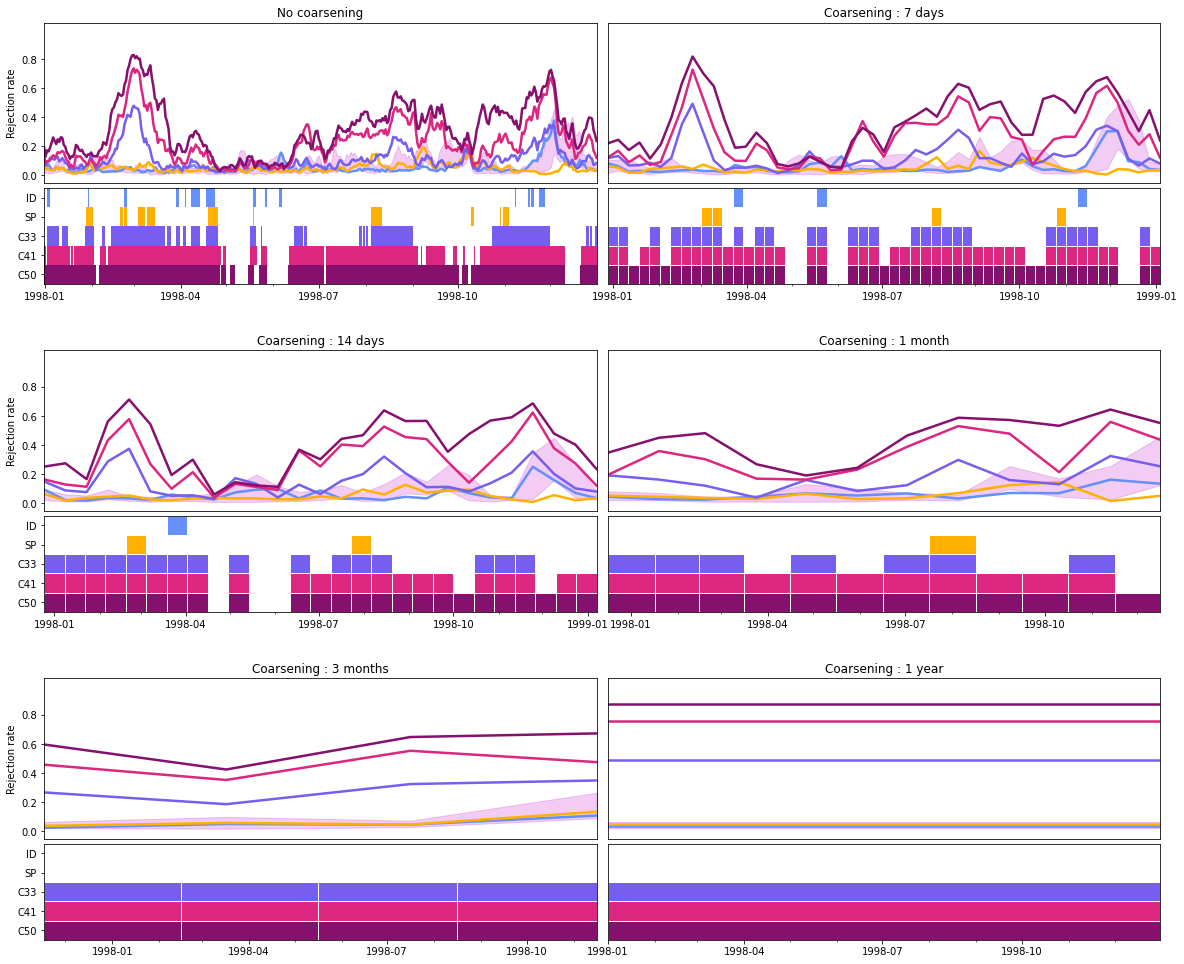

time: 1.52 s


In [12]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
import re

p = re.compile('(\d+)\s*(\w+)')

facs_t = ['1D', '7D', '14D', '1MS', '3MS', '1Y']
    
gs = GridSpec(9, 2, hspace=0.05, wspace=0.02, height_ratios=[1, 0.6, 0.35] * 3)
fig = plt.figure(figsize=(20, 18))
line_axes = []
pcmesh_axes = []
eid = ensembles_in_decisions['comb']
thesetitles = ['ID', 'SP', 'C33', 'C41', 'C50']
colors = []
for i, ens in enumerate(eid):
    colors.extend(
        LinearSegmentedColormap.from_list(
            'ob',
            ['#FFFFFF', COLORS[i]],
            N=2,
        )(np.linspace(0, 1, 2)).tolist())
cmap = ListedColormap(colors)

for i in range(9):
    for j in range(2):
        if i % 3 == 2:
            fig.add_subplot(gs[i, j]).set_visible(False)
        if i % 3 == 0:
            line_axes.append(fig.add_subplot(gs[i, j]))
        if i % 3 == 1:
            pcmesh_axes.append(fig.add_subplot(gs[i, j]))
nicer_unit = {
    'D': 'day',
    'w': 'week',
    'M': 'month',
    'Y': 'year',
}
for i, (fac, lax, pax) in enumerate(zip(facs_t, line_axes, pcmesh_axes)):
    print(fac)
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/time_coarsening/avg_{varname}_{fac}_1998_v2.nc")
    ti = glavgres.time.values
    lq05, lq95 = glavgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
    lines = glavgres.sel(ensemble=eid).mean(dim='sel')
    to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')
    if fac != '1Y':
        lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
        for t, c, l in zip(thesetitles, COLORS, lines):
            lax.plot(ti, l, color=c, lw=2.5, label=t)
        pax.pcolormesh(
            ti, 
            np.arange(len(to_plot.ensemble))[::-1],
            to_plot.values + np.arange(0, 10, 2)[:, None], 
            shading='nearest',
            cmap=cmap,
            norm=BoundaryNorm(np.arange(11), 11),
            rasterized=True,
            linewidth = 0 if fac == '1D' else 0.5,
            edgecolors="white",
        )
    else:
        lines = [l.values[0] for l in lines]
        lq05, lq95 = [l.values[0] for l in [lq05, lq95]]
        ti = np.asarray([np.datetime64('1998-01-01'), np.datetime64('1998-12-31')])
        lax.fill_between(ti, [lq05, lq05], [lq95, lq95], color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
        for t, c, l in zip(thesetitles, COLORS, lines):
            lax.plot(ti, [l, l], color=c, lw=2.5, label=t)
        pax.pcolormesh(
            ti,
            np.arange(5, -1, -1),
            to_plot.values + np.arange(0, 10, 2)[:, None], 
            cmap=cmap,
            norm=BoundaryNorm(np.arange(11), 11),
            rasterized=True,
            linewidth = 0 if fac == '1D' else 0.5,
            edgecolors="white",
        )
    lax.set_xticks([])
    lax.set_xlim(ti[[0, -1]])
    if fac == '1D':
        title = 'No coarsening'
    else:
        num, unit = p.match(fac).groups()
        title = f'Coarsening : {num} {nicer_unit[unit[0]]}{"s" if int(num) > 1 else ""}'
    lax.set_title(title)
    lax.set_ylim([-0.05, 1.05])
    if i % 2 == 0:
        lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
        pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
        lax.set_ylabel('Rejection rate')
    else:
        lax.set_yticks([])
        pax.set_yticks([])
    pax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    pax.xaxis.set_minor_locator(mdates.MonthLocator())
# line_axes[0].legend(loc='upper center', ncol=2)
# plt.show()
plt.savefig('Figures/Final/time_coarsening.pdf')

# Sweep n_sam

In [ ]:
varname = 't_850hPa'
test = 'KS'
vmap = metadata["variablemap"][varname]
bigname = vmap[1]
h = vmap[0][:2]
n_sel = metadata["n_sel"]
n_mem = metadata["n_mem"]
replace = metadata["replace"]
bs = metadata["boundary_size"]
rounding = metadata["rounding"]
freq = '1D'

# darr0 = loaddarr(varname, bigname, ensembles, np.arange(108, 120), 'comb', True, False, bs, False).load()
n_samples = [10, 25, 50]
coord_results = {
    'ensemble': eir,
    'time': darr0.time.values,
    'rlat': darr0.rlat.values,
    'rlon': darr0.rlon.values,
    'sel': np.arange(n_sel),
}
ana = 'comb'
notref = notref[ana]
ref = ref[ana]
eir = ensembles_in_results[ana]
darr0 = darr0.values


In [8]:
from tqdm import trange

time: 615 µs


In [ ]:
for n_sam in n_samples:
    crit_val = c_alpha * np.sqrt(2 / n_sam)  # Kolmogorov-Smirnov
    print(n_sam, crit_val)

    ofile = Path(f"{PATHBASE}/results/n_sam_sweep/{varname}_{n_sam}_1998.nc")
    if os.path.isfile(ofile):
        continue 
    
    results = xr.DataArray(
        np.zeros([len(v) for v in coord_results.values()]), 
        coords=coord_results,
    )
    csize = 10
    for i in range(0, darr0.shape[2], csize):
        end = min(darr0.shape[2], i + csize)
        b_base = sanitize(cp.asarray(darr0[ref, :, i:end]), rounding)
        for s in trange(n_sel):
            idxs_ref = ran.choice(darr0.shape[-1], n_sam, replace=replace)
            b = b_base[..., idxs_ref]
            to_do, other_args = wraptest(b, test)
            for n in range(len(notref)):
                idxs = ran.choice(darr0.shape[-1], n_sam, replace=replace)
                a = sanitize(cp.asarray(darr0[notref[n], :, i:end][..., idxs]), rounding)
                results[n, :, i:end, :, s] = (cp.abs(to_do(a, *other_args)) > crit_val).get()
    results.to_netcdf(ofile.as_posix())
    glavgres = results.mean(dim=results.dims[2:4]) 
    glavgres.to_netcdf(f"{PATHBASE}/results/n_sam_sweep/avg_{varname}_{n_sam}_1998.nc")

10 0.6073614619083052
25 0.38412911652796833
50 0.2716203031481239


 80%|████████  | 80/100 [04:08<01:02,  3.10s/it]

In [6]:
for n_sam in n_samples:
    crit_val = c_alpha * np.sqrt(2 / n_sam)  # Kolmogorov-Smirnov
    print(n_sam, crit_val)

    ifile = Path(f"{PATHBASE}/results/n_sam_sweep/{varname}_{n_sam}_1998.nc")
    ofile = Path(f"{PATHBASE}/results/n_sam_sweep/avg_{varname}_{n_sam}_1998.nc")
    if ofile.is_file():
        continue
    results = xr.open_dataarray(ifile.as_posix())
    glavgres = results.mean(dim=results.dims[2:4]) 
    glavgres.to_netcdf(ofile.as_posix())

10 0.6073614619083052
25 0.38412911652796833
50 0.2716203031481239
time: 1min 53s


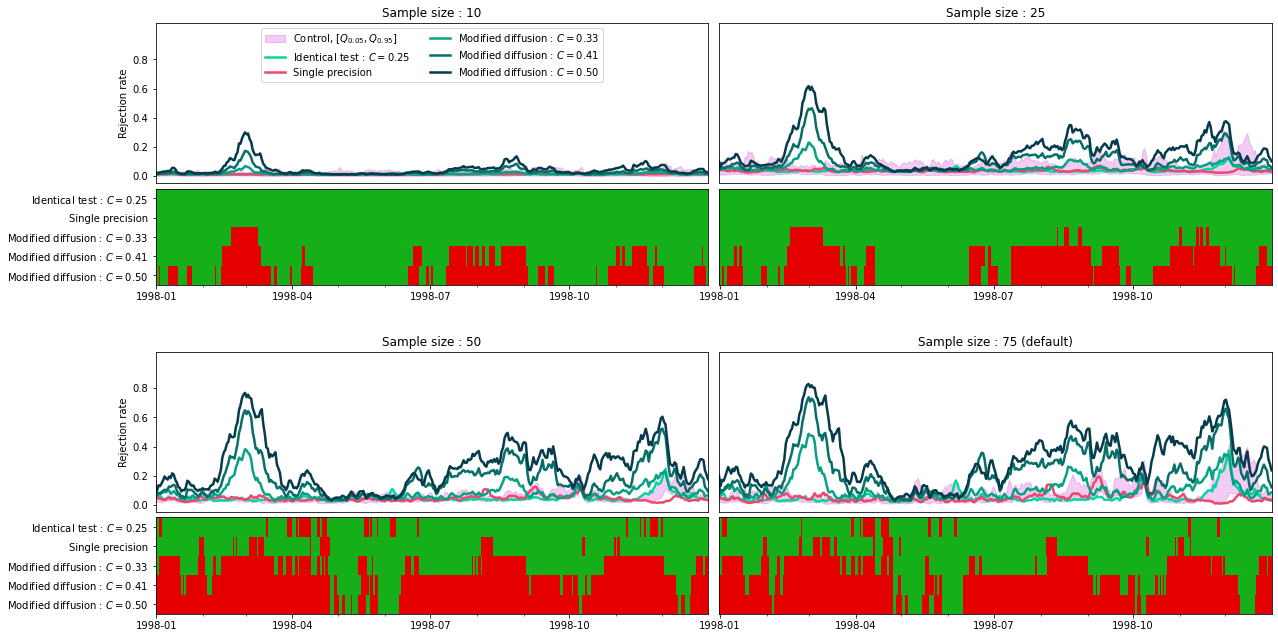

time: 1.4 s


In [11]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure

n_samples = [10, 25, 50, 75]
    
gs = GridSpec(6, 2, hspace=0.05, wspace=0.02, height_ratios=[1, 0.6, 0.35] * 2)
fig = plt.figure(figsize=(20, 12))
line_axes = []
pcmesh_axes = []
C_to_B = LinearSegmentedColormap.from_list("bdb", [COLORS[2], COLORS[4]], N=4)(np.linspace(0, 1, 4))
colors = [C_to_B[0], COLORS[0], C_to_B[1], C_to_B[2], C_to_B[3]]

eid = ensembles_in_decisions['comb']
thesetitles = titles['comb']

for i in range(6):
    for j in range(2):
        if i % 3 == 2:
            fig.add_subplot(gs[i, j]).set_visible(False)
        if i % 3 == 0:
            line_axes.append(fig.add_subplot(gs[i, j]))
        if i % 3 == 1:
            pcmesh_axes.append(fig.add_subplot(gs[i, j]))

for i, (n_sam, lax, pax) in enumerate(zip(n_samples, line_axes, pcmesh_axes)):
    glavgres = xr.open_dataarray(f"{PATHBASE}/results/n_sam_sweep/avg_{varname}_{n_sam}_1998.nc")
    ti = glavgres.time.values
    lq05, lq95 = glavgres.sel(ensemble='control').quantile([0.05, 0.95], dim='sel')
    lines = glavgres.sel(ensemble=eid).mean(dim='sel')
    to_plot = xr.concat([l > lq95 for l in lines], dim='ensemble')
    lax.fill_between(ti, lq05, lq95, color='m', alpha=0.2, label='Control, $[Q_{0.05}, Q_{0.95}]$')
    for t, c, l in zip(thesetitles, colors, lines):
        lax.plot(ti, l, color=c, lw=2.5, label=t)
    lax.set_xticks([])
    lax.set_xlim(ti[[0, -1]])
    pax.pcolormesh(
        ti, 
        np.arange(len(to_plot.ensemble))[::-1],
        to_plot.values, 
        shading='nearest',
        cmap=CMAP,
        vmax=1,
        vmin=0,
        rasterized=True,
        linewidth = 0,
        edgecolors="white",
    )
    title = f'Sample size : {n_sam}' + (' (default)' if n_sam == 75 else '')
    lax.set_title(title)
    lax.set_ylim([-0.05, 1.05])
    if i % 2 == 0:
        lax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
        pax.set_yticks([4, 3, 2, 1, 0], thesetitles)
        lax.set_ylabel('Rejection rate')
    else:
        lax.set_yticks([])
        pax.set_yticks([])
    pax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    pax.xaxis.set_minor_locator(mdates.MonthLocator())
line_axes[0].legend(loc='upper center', ncol=2)
# plt.show()
plt.savefig('Figures/Final/n_sam_sweep.pdf')

# Other random tests

## When to global average ?

two ways to get a sense of the internal variability of an ensemble. Here we use the specific heat flux at the surface because it is causing problems later down the track (see end)
We can either space-average and then compute the std of this time series (blue line) or compute the std on each gridpoint and space-average it (red line). As expected the red line is always much higher than the blue

In [ ]:
varname = "ashfl_s"
i = 0
at_once = 4
bigname = variablemap[varname][1]
fnames = [f"{PATHBASE}/main/{varname}s{j}.nc" for j in range(i, i + at_once)]
darr = xr.open_mfdataset(fnames)[bigname]

fig, axes = plt.subplots(darr.shape[0], 1, tight_layout=True, figsize=(10, 15))
x = np.arange(darr.shape[1])
colors = ["#073B4C", "#118ab2", "#06D6A0", "#ffd166", "#ef476f"]
fig.suptitle(varname)
for i in range(darr.shape[0]):
    ax = axes[i]
    ax.plot(
        x,
        np.std(np.mean(darr[i, ...], axis=(1, 2)), axis=-1),
        color=colors[1],
        label="Space then ensemble",
    )
    ax.plot(
        x,
        np.mean(np.std(darr[i, ...], axis=-1), axis=(1, 2)),
        color=colors[-1],
        label="Ensemble then space",
    )
    ax.grid(True)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("Internal variability")
    ax.set_title(ensembles[i])

axes[-1].legend()

## Effects of the oversampling on the internal variability

In [ ]:
darr = loaddarr("u_10m", [0, 1], "main", False, True, True)
freqs = ["1D", "2D", "1w", "1M"]
fig, axes = plt.subplots(len(freqs), 3, tight_layout=True, figsize=(15, 12))
dims = list(darr.dims)
colors = ["#EF476F", "#FFD166", "#06D6A0", "#118AB2", "#073B4C"]
for i in range(len(freqs)):
    freq = freqs[i]
    newdarr = oversample(darr, freq)
    x = np.arange(len(newdarr["newtime"]))
    axes[i, 0].plot(
        x, np.mean(newdarr[2, ...], axis=(1, 2, 3)), color=colors[2], label="Mean"
    )
    axes[i, 0].fill_between(
        x,
        *np.quantile(np.mean(newdarr[2, ...], axis=(1, 2)), [0, 1], axis=-1),
        color=colors[2],
        alpha=0.2,
        label=f"[0, 1] Quantiles, {ensembles[2]}",
    )
    axes[i, 0].set_ylabel(varname)
    for j in range(newdarr.shape[0]):
        axes[i, 1].plot(
            x,
            np.std(np.mean(newdarr[j, ...], axis=(1, 2)), axis=-1),
            color=colors[j],
            label=ensembles[j],
        )
        axes[i, 1].set_title("Space then ensemble")
        axes[i, 1].set_ylabel("Internal variability")
        axes[i, 2].plot(
            x,
            np.mean(np.std(newdarr[j, ...], axis=-1), axis=(1, 2)),
            color=colors[j],
            label=ensembles[j],
        )
        axes[i, 2].set_title("Ensemble then space")
        axes[i, 2].set_ylabel("Internal variability")
    for ax in axes[i, :]:
        ax.set_xlabel(f"Time, {freqs[i]}")
        ax.grid(True)
axes[-1, 0].legend()
axes[-1, 1].legend()
axes[-1, 2].legend()

## Time-autocorrelation of all variables

To justify oversampling, we compute the time-autocorrelation of all the variables in the reference ensemble. We also compute the average lag after which it goes below $1 \over e$ The results are that most of the variables stay correlated after a month or even two, while a few (u_100m for example) stop being correlated after only 2 days.

In [ ]:
fig, axes = plt.subplots(8, 6, tight_layout=True, figsize=(20, 30))
axes = axes.flatten()
wo = {}
for i, varname in enumerate(variablemap.keys()):
    wo[varname] = []
    ax = axes[i]
    bigname = variablemap[varname][1]
    darr = loaddarr(varname, np.arange(12), "main", True, True, False)
    series = np.mean(darr[2, :, :, :, 0], axis=(1, 2))
    mean = np.mean(series)
    s = 1
    N = len(series)
    howmany = 200  # N - s
    autocorr = np.empty((howmany))
    for k in range(len(autocorr)):
        autocorr[k] = np.sum((series[k:] - mean) * (series[: N - k] - mean))
    autocorr = autocorr / autocorr[0]
    ax.set_title(varname)
    ax.set_xlabel("Time lag [days]")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)
    wo[varname].append(np.where(autocorr < 1 / np.e)[0][0])
    # ax.vlines(wo, 0, 1, "k")
    ax.plot(np.arange(len(autocorr)), autocorr, label=f"Below at $t={wo[varname][0]}$")

    series = darr[2, :, :, :, 0]
    N = series.shape[0]
    s = 1
    mean = np.tensordot(np.ones(N), np.mean(series, axis=0), axes=0)
    autocorr = np.empty((howmany, darr.shape[2], darr.shape[3]))
    for k in range(autocorr.shape[0]):
        autocorr[k] = np.sum(
            (series[k:] - mean[k:]) * (series[: N - k] - mean[: N - k]), axis=0
        )
    to_plot = np.nanmean(
        autocorr / np.tensordot(np.ones(howmany), autocorr[0], axes=0), axis=(1, 2)
    )

    wo[varname].append(np.where(to_plot < 1 / np.e)[0][0])
    ax.plot(np.arange(howmany), to_plot, label=f"Below at $t={wo[varname][1]}$")
    ax.legend()

## To round or not to round

In [ ]:
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "comb"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
months = np.arange(108, 120)
n_t = 100
spurious = {}
landmask = cp.asarray(xr.open_dataarray(f'{PATHBASE}/gridinfo/landmask.nc').values[None, :, :, None])
problematic = ["clct", "clcl", "clcm", "clch", "t_so_first", "t_so_third", "t_so_fifth", "w_so_first", "w_so_third", "w_so_fifth", 'w_snow', 'h_snow', 'hpbl']
land = ["t_so_first", "t_so_third", "t_so_fifth", "w_so_first", "w_so_third", "w_so_fifth", 'w_snow', 'h_snow']
for varname in problematic:
    bigname = variablemap[varname][1]
    darr = loaddarr(varname, bigname, ensembles, months, ana, values=False, bs=bs)
    wheret = np.random.randint(darr.shape[1], size=n_t)
    darr = darr.sel(ensemble=['ref', 'control', 'sp']).isel(time=wheret).load()
    a = cp.asarray(darr.sel(ensemble='ref').values)
    if varname in land:
        a = cp.where(landmask, a, 0)
    a = cp.sort(a, axis=-1)
    spurious[varname] = {}
    for ens in('control', 'sp'):
        nx = cp.sum(~cp.isnan(a), axis=-1)[..., cp.newaxis]
        b = cp.asarray(darr.sel(ensemble=ens).values)
        if varname in land:
            b = cp.where(landmask, b, 0)
        b = cp.sort(b, axis=-1)
        x = cp.concatenate([a, b], axis=-1) # Concat all data
        y1 = (searchsortednd(a, x, side="right") / nx).astype(np.float32)
        y2 = (searchsortednd(b, x, side="right") / nx).astype(np.float32)
        ds = cp.abs(y1 - y2)
        dinds = cp.argmax(ds, axis=-1)
        d = cp.take_along_axis(ds, dinds[..., None], axis=-1).squeeze()
        
        xind = cp.argsort(x, axis=-1)
        x = cp.take_along_axis(x, xind, axis=-1)
        y1 = cp.take_along_axis(y1, xind, axis=-1)
        y2 = cp.take_along_axis(y2, xind, axis=-1)

        y1_m = cp.take_along_axis(y1, dinds[..., None], axis=-1)
        y2_m = cp.take_along_axis(y2, dinds[..., None], axis=-1)
        x_m = cp.take_along_axis(x, dinds[..., None], axis=-1)

        equal_y = cp.where(y2_m > y1_m, searchsortednd(y1, y2_m), searchsortednd(y2, y1_m))
        x_m2 = cp.take_along_axis(x, equal_y, axis=-1)
        x_dists = x_m2 - x_m
        
        small_diff = (x_dists.squeeze() < 1e-4).get()
        rejected = (d.squeeze() > crit_val[freq]['KS']).get()
        result = np.sum(small_diff & rejected) / np.sum(rejected)
        print(varname, ens, f'{result:.3f}')
        spurious[varname][ens] = [small_diff, rejected]
        
        del b, x, y1, y2, ds
        gc.collect()
        
    del a
    gc.collect()
with open('spurious.pkl', 'wb') as handle:
    pkl.dump(spurious, handle)

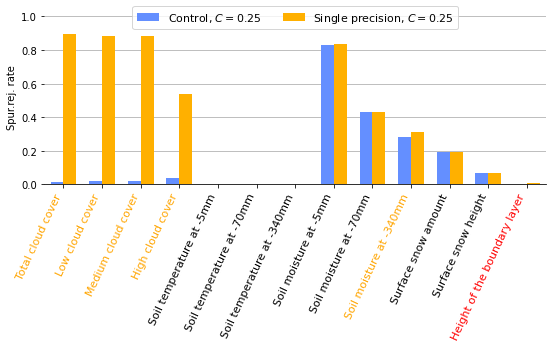

time: 2.12 s


In [10]:
with open('spurious.pkl', 'rb') as handle:
    spurious = pkl.load(handle)

to_plot = np.zeros((len(spurious), 2))
for i, (varname, values) in enumerate(spurious.items()):
    for j, (ens, val) in enumerate(values.items()):
        small_diff, rejected = val
        result = np.sum(small_diff & rejected) / np.sum(rejected)
        to_plot[i, j] = result
        
fig, ax = plt.subplots(figsize=(9, 5))
fig.subplots_adjust(bottom=0.5, top=0.99)

x = np.arange(to_plot.shape[0])
width = 1 / 3
barcenters = np.linspace(-0.5, 0.5, 4)[1:-1]

for key in ['left', 'right', 'top']:
    ax.spines[key].set_visible(False)
ax.grid(True, axis="y", zorder=-10)
thesetitles = ['Control, $C=0.25$', 'Single precision, $C=0.25$']
k = [0, 1]
for j in range(len(k)):
    ax.bar(
        x + barcenters[j],
        to_plot[:, j],
        width,
        color=COLORS[k[j]],
        label=thesetitles[k[j]],
        zorder=10,
    )
ax.set_ylim([0, 1.05])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("Spur.rej. rate")
ax.set_xlim([-0.5, len(x) - 0.5])

ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, 0.85), fontsize=11)
subset = list(spurious.keys())
if subset is not None:
    thisvm = {key: variablemap[key] for key in subset}
else:
    thisvm = variablemap
ax.set_xticks(np.arange(len(thisvm)), labels=[None] * len(thisvm))
    
vlabels = [val[-1] for val in thisvm.values()]
fig.canvas.draw()
ax.set_xticks(np.arange(len(vlabels)))
_ = ax.set_xticklabels(vlabels, rotation=65, ha="right", fontsize=11)
for label, varname in zip(ax.get_xticklabels(), thisvm.keys()):
    if varname == 'hpbl':
        label.set_color('red')
    if varname in ['clcl', 'clcm', 'clch', 'clct', 'w_so_fifth']:
        label.set_color('orange')
plt.savefig('Figures/Final/problematic.pdf', dpi=300)

In [ ]:
from tqdm import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "comb"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
months = np.arange(108, 120)
n_t = 150
n_sel = 100
spurious = {}
landmask = cp.asarray(xr.open_dataarray(f'{PATHBASE}/gridinfo/landmask.nc').values[None, :, :, None])
varname = 'w_so_fifth'
bigname = variablemap[varname][1]
darr = loaddarr(varname, bigname, ensembles, months, ana, values=False, bs=bs)
wheret = np.random.randint(darr.shape[1], size=n_t)
darr = darr.sel(ensemble=['ref', 'control', 'sp']).isel(time=wheret).load()
spurious = [{} for _ in range(n_sel)]
for s in trange(n_sel):
    idxs = [np.random.randint(darr.shape[-1], size=75) for _ in range(darr.shape[0])]
    for ie, ens in enumerate(('control', 'sp')):
        a = cp.asarray(darr.sel(ensemble='ref')[..., idxs[0]].values)
        a = cp.where(landmask, a, 0)
        a = cp.sort(a, axis=-1)
        nx = cp.sum(~cp.isnan(a), axis=-1)[..., cp.newaxis]
        b = cp.asarray(darr.sel(ensemble=ens)[..., idxs[ie + 1]].values)
        b = cp.where(landmask, b, 0)
        b = cp.sort(b, axis=-1)
        x = cp.concatenate([a, b], axis=-1) # Concat all data
        y1 = (searchsortednd(a, x, side="right") / nx).astype(np.float32)
        del a
        gc.collect()
        y2 = (searchsortednd(b, x, side="right") / nx).astype(np.float32)
        del b
        gc.collect()
        ds = cp.abs(y1 - y2)
        dinds = cp.argmax(ds, axis=-1)
        d = cp.take_along_axis(ds, dinds[..., None], axis=-1).squeeze()
        del ds
        gc.collect()
        xind = cp.argsort(x, axis=-1)
        x = cp.take_along_axis(x, xind, axis=-1)
        y1 = cp.take_along_axis(y1, xind, axis=-1)
        y2 = cp.take_along_axis(y2, xind, axis=-1)

        y1_m = cp.take_along_axis(y1, dinds[..., None], axis=-1)
        y2_m = cp.take_along_axis(y2, dinds[..., None], axis=-1)
        x_m = cp.take_along_axis(x, dinds[..., None], axis=-1)

        equal_y = cp.where(y2_m > y1_m, searchsortednd(y1, y2_m), searchsortednd(y2, y1_m))
        x_m2 = cp.take_along_axis(x, equal_y, axis=-1)
        x_dists = x_m2 - x_m

        small_diff = (x_dists.squeeze() < 1e-4).get()
        rejected = (d.squeeze() > crit_val[freq]['KS']).get()
        result = np.sum(small_diff & rejected) / np.sum(rejected)
        spurious[s][ens] = [np.mean(small_diff, axis=(1, 2)), np.mean(rejected, axis=(1, 2)), np.mean(small_diff & rejected, axis=(1, 2))]

        del y1, y2, x
        gc.collect()

        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
    break
#with open('spurious_w_so_fifth.pkl', 'wb') as handle:
#    pkl.dump(spurious, handle)

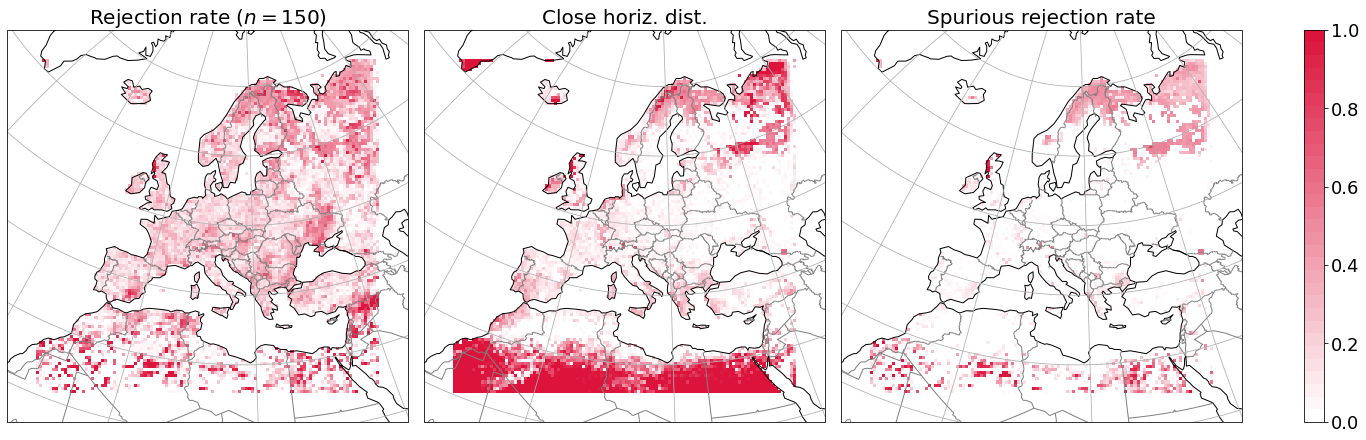

time: 5.76 s


In [92]:
fig, axes = create_axes(1, 3)
lon, lat = darr.lon.values, darr.lat.values
to_plot = [rejected, small_diff & landmask[..., 0].get(), small_diff & rejected  & landmask[..., 0].get()]
to_plot = [np.mean(tplt, axis=0) for tplt in to_plot]
titles = ['Rejection rate ($n=150$)', 'Close horiz. dist.', 'Spurious rejection rate']
for ax, tplt, title in zip(axes, to_plot, titles):
    ax.gridlines()
    im = ax.pcolormesh(
        lon,
        lat,
        tplt,
        transform = ctp.crs.PlateCarree(),
        cmap = CMAP,
        vmin = 0,
        vmax = 1,
    )
    ax.set_title(title)
plt.colorbar(im, ax=axes)
plt.savefig(f'Figures/Final/investigate_w_so_fifth_spatial.pdf')

In [25]:
with open('spurious_w_so_fifth.pkl', 'rb') as handle:
    spurious = pkl.load(handle)

spurious_transposed = {}
for ens in spurious[0]:
    spurious_transposed[ens] = np.zeros((len(spurious), 3, len(spurious[0][ens][0])))
    for s in range(len(spurious)):
        spurious_transposed[ens][s, :, :] = np.asarray(spurious[s][ens])

time: 49 ms


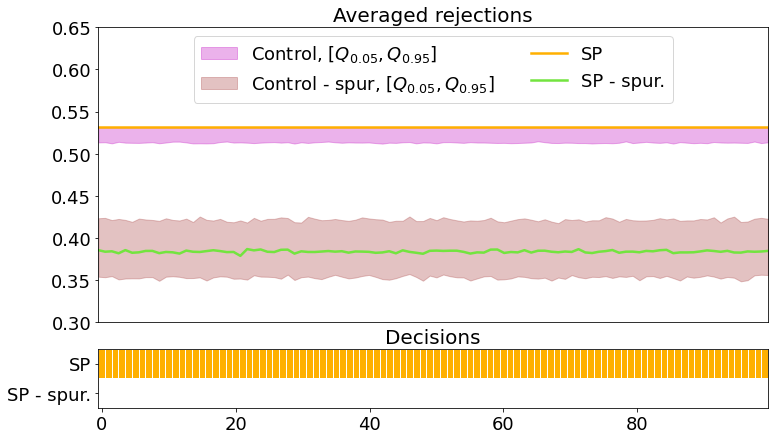

time: 546 ms


In [90]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

varname = 'w_so_fifth'
ti = np.arange(len(spurious))
lq051, lq951 = np.quantile(spurious_transposed['control'][:, 1, :], q=[0.05, 0.6], axis=-1)
lq052, lq952 = np.quantile(spurious_transposed['control'][:, 1, :] - spurious_transposed['control'][:, 2, :], q=[0.05, 0.95], axis=-1)

lines = [
    np.mean(spurious_transposed['sp'][:, 1, :], axis=-1),
    np.mean(spurious_transposed['sp'][:, 1, :] - spurious_transposed['sp'][:, 2, :], axis=-1)
]
to_plot = np.asarray([l > lq95 for l, lq95 in zip(lines, [lq951, lq952])])

gs = GridSpec(2, 1, hspace=0.15, wspace=0.02, height_ratios=[1, 0.2])
fig = plt.figure(figsize=(12, 7))
lax = fig.add_subplot(gs[0])
pax = fig.add_subplot(gs[1])
colors_ = [COLORS[1], '#73e43f']
lax.fill_between(ti, lq051, lq951, color='m', alpha=.3, label='Control, $[Q_{0.05}, Q_{0.95}]$')
lax.fill_between(ti, lq052, lq952, color='#a43737', alpha=.3, label='Control - spur, $[Q_{0.05}, Q_{0.95}]$')

thesetitles = ['SP', 'SP - spur.']
for t, c, l in zip(thesetitles, colors_, lines):
    lax.plot(ti, l, color=c, lw=2.5, label=t)
lax.set_xticks([])
lax.set_xlim(ti[[0, -1]])
colors = []
for c in colors_:
    colors.extend(
        LinearSegmentedColormap.from_list(
            'ob',
            ['#FFFFFF', c],
            N=2,
        )(np.linspace(0, 1, 2)).tolist())
cmap = ListedColormap(colors)
pax.pcolormesh(
    ti, 
    np.arange(len(to_plot))[::-1],
    to_plot + np.arange(0, 4, 2)[:, None], 
    shading='nearest',
    cmap=cmap,
    norm=BoundaryNorm(np.arange(5), 5),
    rasterized=True,
    linewidth = 0.5,
    edgecolors="white",
)
lax.set_ylim([0.3, 0.65])
pax.set_yticks([1, 0], thesetitles)
lax.set_ylabel('')
lax.legend(loc='upper center', ncol=2, fontsize=18)
lax.set_title('Averaged rejections')
pax.set_title('Decisions')
plt.savefig(f'Figures/Final/investigate_w_so_fifth.pdf')

In [60]:
np.amax(spurious_transposed['control'][:, 1, :], axis=-1)

array([0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161861,
       0.53161861, 0.53161861, 0.53161861, 0.53161861, 0.53161

time: 2.45 ms


## Explicit KS

When performing the KS test, we compare two empirical cumulative distributions. We pick 50 grid and time points at random, plot the two cumulative functions, corresponding to the ref and control ensembles, for each of these points

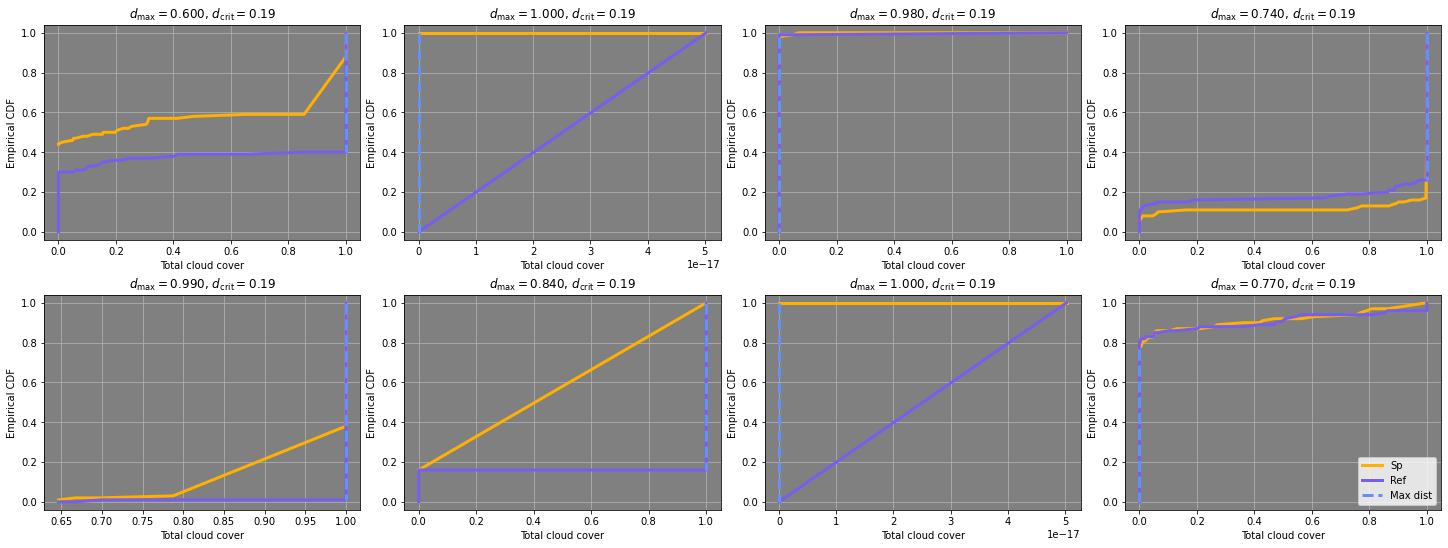

time: 4 s


In [9]:
%matplotlib inline


# dask.config.set({"array.slicing.split_large_chunks": True})
fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(20, 7.5))
axes = np.atleast_2d(axes)
# fig.suptitle("Reference vs. Control, at random points")
axes = axes.flatten()
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "comb"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
varname = "clct"
bigname = variablemap[varname][1]
month = 101
darr = loaddarr(varname, bigname, ensembles, month, ana, values=False, bs=bs)
wheres = [[np.random.randint(l, j) for l, j in zip([0, 0, 0], darr.shape[1:4])] for s in range(8)]
do_round = False
def numpy_searchsortednd(
    a, x, **kwargs
):  # https://stackoverflow.com/questions/40588403/vectorized-searchsorted-numpy + cupy + reshapes
    orig_shape = a.shape[:-1]
    print(orig_shape)
    a = a.reshape(np.prod(orig_shape), -1)
    x = x.reshape(np.prod(orig_shape), -1)
    m, n = a.shape
    max_num = np.maximum(a.max() - a.min(), x.max() - x.min()) + 1
    r = max_num * np.arange(a.shape[0])[:, None]
    p = np.searchsorted((a + r).ravel(), (x + r).ravel(), **kwargs).reshape(m, -1)
    return (p - n * (np.arange(m)[:, None])).reshape((*orig_shape, -1))


for s in range(len(axes)):
    where = wheres[s]
    b = darr[ref[ana], where[0], where[1], where[2], :]
    a = darr[notref[ana][2], where[0], where[1], where[2], :]
    if do_round:
        a = np.around(a, 5)
        b = np.around(b, 5)
    a, b = np.sort(a, axis=-1), np.sort(b, axis=-1)
    # print(np.sum(np.isnan(a)))
    nx = np.sum(~np.isnan(a), axis=-1)
    x = np.concatenate([a, b], axis=-1)  # Concat all data
    y1 = np.searchsorted(a, x, side="right") / nx
    y2 = np.searchsorted(b, x, side="right") / nx
    xind = np.argsort(x)
    x = x[xind]
    y1 = y1[xind]
    y2 = y2[xind]
    ds = np.abs(y1 - y2)
    dind = np.argmax(ds)
    d = ds[dind]
    rej = d > c_alpha * np.sqrt(2 / nx)
    ax = axes[s]
    if rej:
        ax.set_facecolor("gray")
    # ax.set_xlim([-0.1, 1.1])
    # ax2 = ax.twinx()
    ax.plot(x, y1, color=COLORS[1], lw=3, label="Sp")
    ax.plot(x, y2, color=COLORS[2], lw=3, label="Ref")
    ax.plot(
        [x[dind], x[dind]],
        [y1[dind], y2[dind]],
        "--",
        color=COLORS[0],
        label="Max dist",
        lw=3,
    )
    ax.set_ylim([-0.04, 1.04])
    ax.set_title(
        r"$d_{\mathrm{max}}="
        + f"{d:.3f}$, "
        + r"$d_{\mathrm{crit}}"
        + f"={c_alpha * np.sqrt(2 / nx):.2f}$"
    )
    ax.set_xlabel(variablemap[varname][-1])
    ax.set_ylabel("Empirical CDF")
    ax.grid(True)
    if s == (len(axes) - 1):
        ax.legend()
plt.savefig(f"Figures/KS_{varname}{'_round' if do_round else ''}.png", dpi=300)

In [5]:
a #sp

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02445806, 0.04999723, 0.04999723, 0.04999729, 0.04999729,
       0.04999729, 0.04999729, 0.05998267, 0.06344898, 0.06567092,
       0.06567092, 0.06567092, 0.06567092, 0.06894602, 0.07501961,
       0.07618566, 0.07618566, 0.07632698, 0.07700379, 0.08377077,
       0.08377077, 0.08377077, 0.09448518, 0.09973879, 0.09982635,
       0.10366119, 0.12582912, 0.12582912, 0.13134469, 0.13370104,
       0.13699432, 0.14858194, 0.14932443, 0.18426748, 0.19074084,
       0.32200372, 0.34399408, 0.39160842, 0.4948154 , 0.5704238 ,
       0.6018606 , 0.62253946, 0.65690845, 0.68837017, 0.69805604,
       0.72584623, 0.7841294 , 0.7854851 , 0.8010438 , 0.8984501 ,
       0.9136349 , 0.9149638 , 0.93904644, 0.9890689 , 0.99247754,
       0.999998  , 0.999998  , 0.999998  , 0.999998  , 0.99999

time: 2.26 ms


In [6]:
b #dp

array([5.0247593e-17, 5.0247593e-17, 5.0247593e-17, 5.0247593e-17,
       5.0247593e-17, 5.0247593e-17, 5.0247593e-17, 5.0247593e-17,
       7.0490758e-04, 4.9999990e-02, 4.9999990e-02, 4.9999990e-02,
       4.9999990e-02, 4.9999990e-02, 4.9999990e-02, 4.9999990e-02,
       4.9999990e-02, 4.9999990e-02, 4.9999990e-02, 4.9999990e-02,
       5.4469515e-02, 6.2869906e-02, 6.8948753e-02, 6.9990240e-02,
       9.1357104e-02, 9.1357104e-02, 9.8941468e-02, 1.1139242e-01,
       1.1998229e-01, 1.4858457e-01, 1.4858457e-01, 1.6932005e-01,
       1.9274285e-01, 2.7640691e-01, 4.1557842e-01, 5.2494216e-01,
       5.4834062e-01, 5.6170279e-01, 5.8279926e-01, 6.1316448e-01,
       6.3760453e-01, 6.8972278e-01, 7.1113473e-01, 7.1454823e-01,
       7.8855217e-01, 7.9031098e-01, 8.0595070e-01, 8.2706028e-01,
       8.3116531e-01, 8.8258392e-01, 8.9663625e-01, 9.5174325e-01,
       9.5418668e-01, 9.6089512e-01, 9.9530923e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e

time: 2.34 ms


In [29]:
month = 105
darr = loaddarr(varname, bigname, ensembles, month, ana, values=False, bs=bs)
freq = '1D'
test = 'KS'
ana = 'main'
darr = oversample(darr, freq)
darrcp = cp.asarray(darr.values)
res = one_s(darrcp, ref[ana], notref[ana], n_sam[freq], replace, test, crit_val[freq], rounding=None).get()

time: 4.18 s


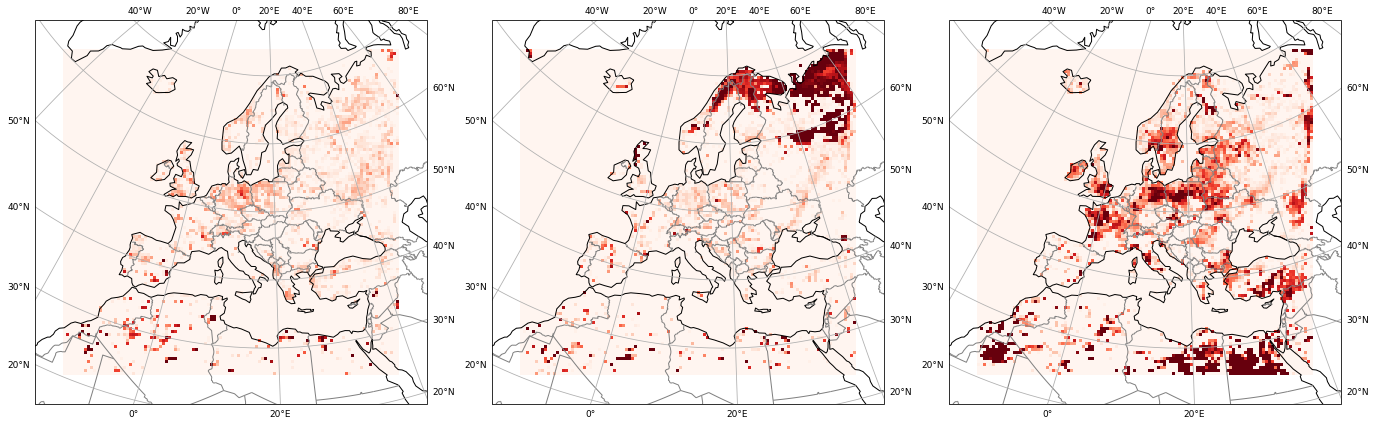

time: 1.1 s


In [46]:
fig, axes = create_axes(1, 3)
transform = ctp.crs.PlateCarree()
axes[0].pcolormesh(darr.lon.values, darr.lat.values, np.mean(res[1], axis=0), transform=transform, cmap='Reds', vmin=0, vmax=1)
axes[1].pcolormesh(darr.lon.values, darr.lat.values, np.mean(res[2], axis=0), transform=transform, cmap='Reds', vmin=0, vmax=1)
axes[2].pcolormesh(darr.lon.values, darr.lat.values, np.mean(res[3], axis=0), transform=transform, cmap='Reds', vmin=0, vmax=1)
for ax in axes:
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

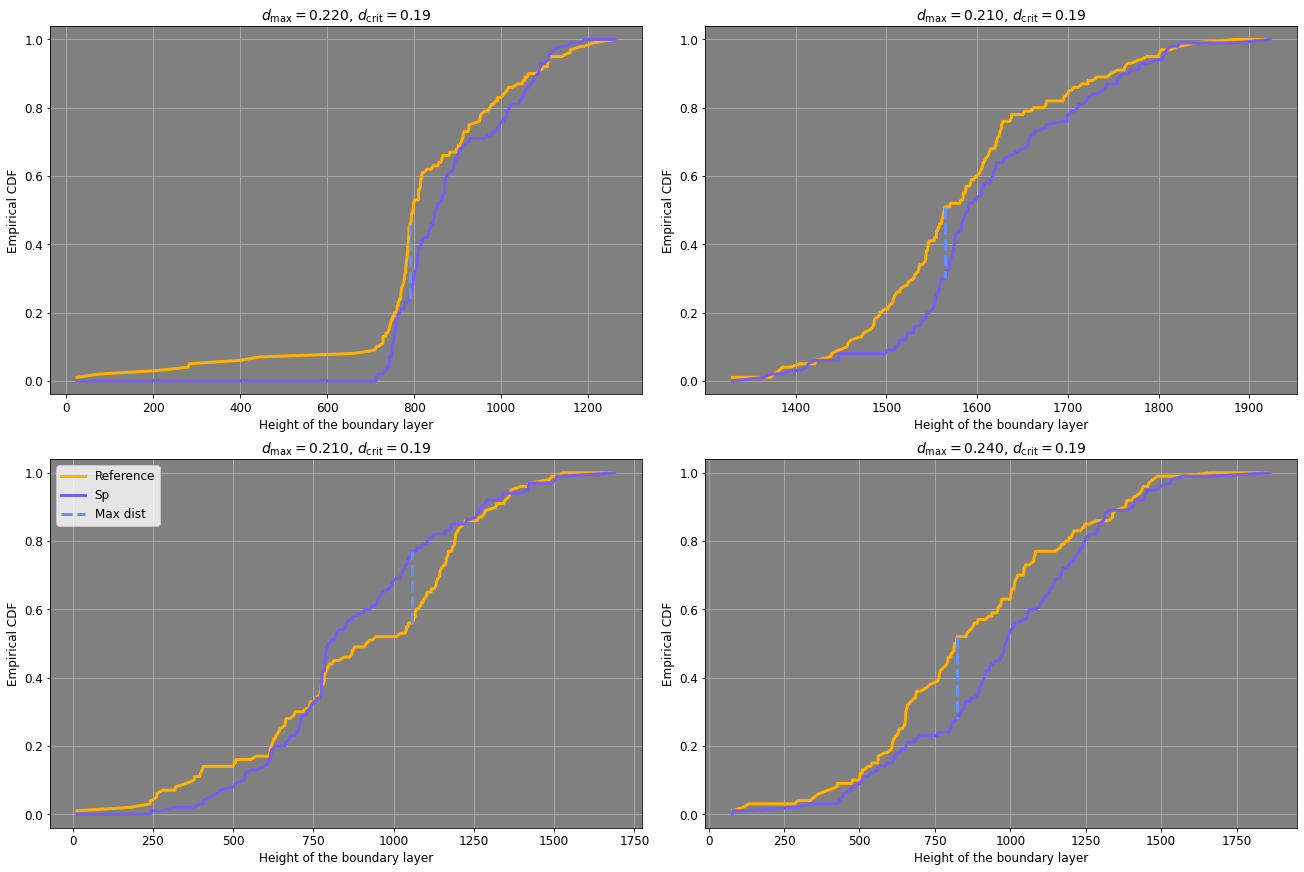

time: 6.52 s


In [10]:
%matplotlib inline

# dask.config.set({"array.slicing.split_large_chunks": True})
fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(18, 12))
axes = np.atleast_1d(axes)
# fig.suptitle("Reference vs. Control, at random points")
axes = axes.flatten()
variablemap = metadata["variablemap"]
decision_quantile = metadata["decision_quantile"]
ana = "comb"
ensembles = metadata["ensembles"][ana]
ensembles_in_decisions = metadata["ensembles_in_decisions"][ana]
bs = metadata["boundary_size"]
varname = "hpbl"
bigname = variablemap[varname][1]
month = 101
darr = loaddarr(varname, bigname, ensembles, month, ana, values=False, bs=bs)


def numpy_searchsortednd(
    a, x, **kwargs
):  # https://stackoverflow.com/questions/40588403/vectorized-searchsorted-numpy + cupy + reshapes
    orig_shape = a.shape[:-1]
    print(orig_shape)
    a = a.reshape(np.prod(orig_shape), -1)
    x = x.reshape(np.prod(orig_shape), -1)
    m, n = a.shape
    max_num = np.maximum(a.max() - a.min(), x.max() - x.min()) + 1
    r = max_num * np.arange(a.shape[0])[:, None]
    p = np.searchsorted((a + r).ravel(), (x + r).ravel(), **kwargs).reshape(m, -1)
    return (p - n * (np.arange(m)[:, None])).reshape((*orig_shape, -1))

s=0
savestate = [None] * len(axes)
rejected = []
notrejected = []
lon = darr.lon.values
lat = darr.lat.values
while s < len(axes):
    where = [np.random.randint(l, j) for l, j in zip([0, 85, 85], darr.shape[1:4])]
    b = darr[ref[ana], where[0], where[1], where[2], :]
    a = darr[notref[ana][2], where[0], where[1], where[2], :]
    # a, b = sanitize(a, 4).get(), sanitize(b, 4).get()
    a, b = np.sort(a, axis=-1), np.sort(b, axis=-1)
    # print(np.sum(np.isnan(a)))
    nx = np.sum(~np.isnan(a), axis=-1)
    x = np.concatenate([a, b], axis=-1)  # Concat all data
    y1 = np.searchsorted(a, x, side="right") / nx
    y2 = np.searchsorted(b, x, side="right") / nx
    xind = np.argsort(x)
    x = x[xind]
    y1 = y1[xind]
    y2 = y2[xind]
    ds = np.abs(y1 - y2)
    dind = np.argmax(ds)
    d = ds[dind]
    rej = d > c_alpha * np.sqrt(2 / nx)
    if rej:
        ax = axes[s]
        ax.set_facecolor("gray")
        # ax.set_xlim([-0.1, 1.1])
        # ax2 = ax.twinx()
        ax.plot(x, y1, color=COLORS[1], lw=3, label="Reference")
        ax.plot(x, y2, color=COLORS[2], lw=3, label="Sp")
        ax.plot(
            [x[dind], x[dind]],
            [y1[dind], y2[dind]],
            "--",
            color=COLORS[0],
            label="Max dist",
            lw=3,
        )
        ax.set_ylim([-0.04, 1.04])
        ax.set_title(
            r"$d_{\mathrm{max}}="
            + f"{d:.3f}$, "
            + r"$d_{\mathrm{crit}}"
            + f"={c_alpha * np.sqrt(2 / nx):.2f}$"
        )
        ax.set_xlabel(variablemap[varname][-1])
        ax.set_ylabel("Empirical CDF")
        ax.grid(True)
        s += 1
        if s == (len(axes) - 1):
            ax.legend()
plt.savefig(f"Figures/Many_KS_{varname}.png", dpi=300)

In [61]:
np.argmax(y1 == y2[dind])

144

time: 2.15 ms
